In [11]:
from typing import Union
from urllib.parse import unquote, quote
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import inchi
from rdkit.Chem.MolStandardize import rdMolStandardize
import pickle
from mordred import Calculator, descriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors as Descriptors
import os
from rdkit import Chem
from rdkit import RDPaths
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolDraw2DSVG

from bokeh.plotting import ColumnDataSource, figure, output_file, show
from sklearn.decomposition import PCA
from bokeh.io import output_notebook

import pandas as pd
from rdkit.Chem import inchi
from rdkit import Chem

import shap
shap.initjs()


import pandas as pd

from rdkit.Chem import AddHs
from rdkit.Chem import inchi
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize import Standardizer
from rdkit.Chem import MolStandardize
from collections import Counter

import subprocess

from pandarallel import pandarallel
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

import warnings

# To ignore all deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# To ignore all warnings (not recommended for development, but can be useful in production)
warnings.filterwarnings("ignore")


import logging
from rdkit import RDLogger

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')

def standardized_smiles(smiles):
    standardizer = Standardizer()
    smiles_original = smiles

    # Read SMILES and convert it to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
 
    try:
        smiles_clean_counter = Counter()
        mol_dict = {}
        is_finalize = False

        for _ in range(5):
            
            #This solved phosphate oxidation in most cases but introduces a problem for some compounds: eg. geldanamycin where the stable strcutre is returned
            inchi_standardised = Chem.MolToInchi(mol)
            mol = Chem.MolFromInchi(inchi_standardised)
            
            # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
            mol = rdMolStandardize.Cleanup(mol) 
            # if many fragments, get the "parent" (the actual mol we are interested in) 
            mol = rdMolStandardize.FragmentParent(mol)
            # try to neutralize molecule
            uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
            
            mol = uncharger.uncharge(mol)# standardize molecules using MolVS and RDKit
            mol = standardizer.charge_parent(mol)
            mol = standardizer.isotope_parent(mol)
            mol = standardizer.stereo_parent(mol)
            
            #Normalize tautomers 
            #Method 1
            normalizer = MolStandardize.tautomer.TautomerCanonicalizer()
            mol = normalizer.canonicalize(mol)
            
            #Method 2
            te = rdMolStandardize.TautomerEnumerator() # idem
            mol = te.Canonicalize(mol)
            
            #Method 3
            mol = standardizer.tautomer_parent(mol)
       
    
            #Final Rules
            mol = standardizer.standardize(mol)
            mol_standardized = mol

            # convert mol object back to SMILES
            smiles_standardized = Chem.MolToSmiles(mol_standardized)

            if smiles == smiles_standardized:
                is_finalize = True
                break

            smiles_clean_counter[smiles_standardized] += 1
            if smiles_standardized not in mol_dict:
                mol_dict[smiles_standardized] = mol_standardized

            smiles = smiles_standardized
            mol = Chem.MolFromSmiles(smiles)

        if not is_finalize:
            # If the standardization process is not finalized, we choose the most common SMILES from the counter
            smiles_standardized = smiles_clean_counter.most_common()[0][0]
            # ... and the corresponding mol object
            #mol_standardized = mol_dict[smiles_standardized]
                
        return smiles_standardized 
    
    except:     
        
        return "Cannot_do"    
    
from dimorphite_dl.dimorphite_dl import DimorphiteDL

def protonate_smiles(smiles):

    dimorphite = DimorphiteDL(min_ph=7.0, max_ph=7.0, pka_precision=0)
    protonated_smiles = dimorphite.protonate(smiles)

    #print("protonated_smiles")

    if len(protonated_smiles) > 0:
                protonated_smiles = protonated_smiles[0]
            
    return protonated_smiles
    
def smiles_to_inchikey(smiles):
 
    try:
        
        # Convert SMILES to a molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Convert the molecule object to an InChI string
        inchi_string = Chem.MolToInchi(mol)
        # Convert the InChI string to an InChIKey
        inchi_key = Chem.inchi.InchiToInchiKey(inchi_string)
        
        return inchi_key
    
    except:     
        
        return "Cannot_do"    
    
def MorganFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(x,2,2048))


def MACCSKeysFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMACCSKeysFingerprint(x))

def get_num_charged_atoms_neg(mol):
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) <= 0:
            negative += 1
     
    return negative

def get_num_charged_atoms_pos(mol):
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) >= 0:
            positive += 1
    return positive

def get_assembled_ring(mol):
    ring_info = mol.GetRingInfo()
    num_ring = ring_info.NumRings()
    ring_atoms = ring_info.AtomRings()
    num_assembled = 0
     
    for i in range(num_ring):
        for j in range(i+1, num_ring):
            x = set(ring_atoms[i])
            y = set(ring_atoms[j])
            if not x.intersection(y): # 2つの環が縮環でない場合に
                for x_id in x:
                    x_atom = mol.GetAtomWithIdx(x_id)
                    neighbors = [k.GetIdx() for k in x_atom.GetNeighbors()]
                    for x_n in neighbors:
                        if x_n in y: # 環同士を繋ぐ結合があるか否か
                            num_assembled += 1
     
    return num_assembled

def get_num_stereocenters(mol):
    return AllChem.CalcNumAtomStereoCenters(mol) + AllChem.CalcNumUnspecifiedAtomStereoCenters(mol)

def calc_descriptors(dataframe):
    mols = dataframe.smiles_r.apply(Chem.MolFromSmiles)
    #mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in mols]
    descr = []
    for m in mols:
        descr.append([Descriptors.TPSA(m),
               Descriptors.NumRotatableBonds(m),
               AllChem.CalcNumRings(m),
               Descriptors.NumAromaticRings(m),
               Descriptors.NumHAcceptors(m),
               Descriptors.NumHDonors(m),
               Descriptors.FractionCSP3(m),
               Descriptors.MolLogP(m) ,
               Descriptors.NHOHCount(m),
               Descriptors.NOCount(m),
               Descriptors.NumHeteroatoms(m),
               get_num_charged_atoms_pos(m),
               get_num_charged_atoms_neg(m),
               get_assembled_ring(m),
               get_num_stereocenters(m)])
    descr = np.asarray(descr)
    return(descr)

descs = [ 'PSA', 'n_rot_bonds', 'n_rings', 'n_ar_rings',
         'n_HBA', 'n_HBD', 'Fsp3', 'logP', 'NHOHCount', 'NOCount', 'NumHeteroatoms',
        'n_positive', '_n_negative', 'n_ring_asmbl', 'n_stereo']

def calc_all_fp_desc(data):
   
    calc = Calculator(descriptors, ignore_3D=True)
    print(len(calc.descriptors))
    Ser_Mol = data['smiles_r'].apply(Chem.MolFromSmiles)
    # as pandas
    Mordred_table=  calc.pandas(Ser_Mol)
    Mordred_table = Mordred_table.astype('float')
    #Mordred_table['smiles_r'] = model_tox_data['smiles_r']
    
    MACCSfingerprint_array = np.stack(data['smiles_r'].apply(MACCSKeysFingerprint))
    MACCS_collection = []
    for x in np.arange(MACCSfingerprint_array.shape[1]):
        x = "MACCS"+str(x)
        MACCS_collection.append(x)
    MACCSfingerprint_table = pd.DataFrame(MACCSfingerprint_array, columns=MACCS_collection)


    MorganFingerprint_array = np.stack(data['smiles_r'].apply(MorganFingerprint))
    Morgan_fingerprint_collection = []
    for x in np.arange(MorganFingerprint_array.shape[1]):
        x = "Mfp"+str(x)
        Morgan_fingerprint_collection.append(x)
    Morgan_fingerprint_table = pd.DataFrame(MorganFingerprint_array, columns=Morgan_fingerprint_collection)

    
    a=calc_descriptors(data)
    descdf=pd.DataFrame(a, columns=descs)
    descdf_approved=descdf.reset_index(drop=True)
    descdf_approved
    
    tox_model_data= pd.concat([data, Morgan_fingerprint_table, MACCSfingerprint_table, descdf_approved, Mordred_table], axis=1)
    tox_model_data
    
    return(tox_model_data)
    
    
liv_data = [ "3",  "5",  "6",  "7",  "8",  "11", "14", "15", "16"]

def predict_individual_liv_data(data_dummy, features, endpoint):#predict animal data
    
    loaded_rf = pickle.load(open(f"bestlivmodel_{endpoint}_model.sav", 'rb'))
    X = data_dummy[features]
    X = X.values
    y_proba =  loaded_rf.predict_proba(X)[:,1]  
    
    return(y_proba)

def predict_individual_cmax_data(data_dummy, features, endpoint):#predict animal data
    
    regressor = pickle.load(open(f"bestlivmodel_{endpoint}_model.sav", 'rb'))

    X = data_dummy[features]
    X = X.values
    #Add predictions to held out test set dili
    y_pred = regressor.predict(X)
    
    return(y_pred)

def predict_liv_all(data):
    #Read columns needed for rat data
    file = open(f"./features_morgan_mordred_maccs_physc.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]
    
    data_dummy = data

    for endpoint in liv_data:
        #print(endpoint)
        y_proba = predict_individual_liv_data(data_dummy, features, endpoint) 
        data[endpoint] = y_proba
        
    for endpoint in ["median pMolar unbound plasma concentration" ,
               "median pMolar total plasma concentration"]:
        y_proba = predict_individual_cmax_data(data_dummy, features, endpoint) 
        data[endpoint] = y_proba
    
    return(data)


def predict_DILI(data):#log human_VDss_L_kg model
    
    #Read columns needed for rat data
    file = open(f"./features_morgan_mordred_maccs_physc.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]
    
    features = list(features) + ["median pMolar unbound plasma concentration", "median pMolar total plasma concentration"] + list(liv_data) 
    loaded_rf = pickle.load(open("./final_dili_model.sav", 'rb'))
    #Note this mode was trained on all data before releasing (not just ncv data)

    X = data[features]
    y_proba =  loaded_rf.predict_proba(X)[:,1]
    best_thresh = 0.612911
    print('Best Threshold=%f' % (best_thresh))
    
    y_pred  = [ 1 if y_proba>best_thresh  else 0] 
    
    explainer = shap.TreeExplainer(loaded_rf)
    shap_values = explainer.shap_values(X)
    

    shap.force_plot(explainer.expected_value[1], 
    shap_values[1], X.iloc[0],
    matplotlib=True)
    
    
    flat_shaplist = [item for sublist in shap_values[1] for item in sublist]
    
    interpret = pd.DataFrame()
    interpret["name"] = features
    interpret["SHAP"] = flat_shaplist#print(flat_shaplist)
    plt.show()
    # Explaining the 4th instance

    return(interpret, y_proba, y_pred)


def mol2svg(mol):
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()


    

INFO: Pandarallel will run on 112 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
DILIdata= pd.read_csv("Test_data_DILIst_1111.csv")
DILIdata

,smiles_r,TOXICITY,Source_rank,Source,Data,InChIKey,InChIKey14,protonated_smiles_r,Mfp0,Mfp1,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,C#Cc1cccc(N=c2[nH]cnc3cc(OCCOC)c(OCCOC)cc23)c1,1,1,DILIst Classification Oral,DILI,AAKJLRGGTJKAMG-UHFFFAOYSA-N,AAKJLRGGTJKAMG,C#Cc1cccc(N=c2[nH]cnc3cc(OCCOC)c(OCCOC)cc23)c1,0,0,...,0.000000,10.116298,64.016835,393.168856,7.560940,2396.0,43.0,142.0,163.0,6.833333
1,COC1(NC(=O)CSC(F)F)C(=O)N2C(C(=O)O)=C(CSc3nnnn...,1,1,DILIst Classification,DILI,UHRBTBZOWWGKMK-UHFFFAOYSA-N,UHRBTBZOWWGKMK,COC1(NC(=O)CSC(F)F)C(=O)[NH+]2C(C(=O)[O-])=C(C...,0,1,...,6.555357,10.733545,82.269503,496.064645,9.921293,3113.0,51.0,166.0,200.0,7.250000
2,CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)N1CCCC1,1,1,DILIst Classification,DILI,UIEATEWHFDRYRU-UHFFFAOYSA-N,UIEATEWHFDRYRU,CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)[NH+]1CCCC1,0,1,...,6.293419,9.845276,74.440588,367.274390,5.923780,1895.0,34.0,132.0,148.0,6.138889
3,Cc1onc(-c2c(F)cccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)...,1,1,DILIst Classification oral,DILI,UIOFUWFRIANQPC-UHFFFAOYSA-N,UIOFUWFRIANQPC,Cc1onc(-c2c(F)cccc2Cl)c1C(=O)NC1C(=O)[NH+]2C1S...,0,0,...,7.853605,10.768843,83.380114,453.056148,9.639493,2402.0,53.0,170.0,211.0,6.291667
4,CC1OC1[P](=O)(=O)O,1,1,DILIst Classification Oral,DILI,UJNUDOLLRRCQDH-UHFFFAOYSA-N,UJNUDOLLRRCQDH,CC1OC1[P](=O)(=O)O,0,0,...,7.753194,9.180603,57.029675,137.000370,9.785741,61.0,7.0,42.0,48.0,1.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,COC(=O)N=c1[nH]c2ccc(C(=O)c3cccs3)cc2[nH]1,0,1,DILIst Classification,DILI,KYRVNWMVYQXFEU-UHFFFAOYSA-N,KYRVNWMVYQXFEU,COC(=O)N=c1[nH]c2ccc(C(=O)c3cccs3)cc2[nH]1,0,0,...,7.285507,9.858333,70.378545,301.052112,9.407879,994.0,29.0,110.0,129.0,4.666667
1107,CC1CNc2c(cccc2S(=O)(=O)NC(CCCN=C(N)N)C(=O)N2CC...,0,1,DILIst Classification Intravenous,DILI,KXNPVXPOPUZYGB-UHFFFAOYSA-N,KXNPVXPOPUZYGB,CC1CNc2c(cccc2S(=O)(=O)NC(CCC[NH+]=C(N)N)C(=O)...,0,1,...,0.000000,10.488075,71.463013,509.254066,7.072973,3704.0,57.0,180.0,209.0,7.625000
1108,CCC(c1cccc(O)c1)C(C)CN(C)C,0,1,DILIst Classification Oral,DILI,KWTWDQCKEHXFFR-UHFFFAOYSA-N,KWTWDQCKEHXFFR,CCC(c1cccc(O)c1)C(C)C[NH+](C)C,0,1,...,0.000000,9.353834,47.590867,222.185241,5.554631,448.0,21.0,74.0,82.0,3.722222
1109,CC(N)Cc1ccccc1,0,1,DILIst Classification Oral,DILI,KWTSXDURSIMDCE-UHFFFAOYSA-N,KWTSXDURSIMDCE,CC([NH3+])Cc1ccccc1,0,1,...,0.000000,8.564268,38.519688,136.112076,5.671336,126.0,9.0,44.0,46.0,2.333333


In [3]:
literature = pd.read_csv("literature.csv")
literature

,name,smiles
0,2-Butoxyethanol,CCCCOCCO
1,Acitretin,COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C
2,Alpidem,CCCN(CCC)C(=O)CC1=C(N=C2C=CC(Cl)=CN12)C1=CC=C(...
3,Amiodarone,CCCCC1=C(C(=O)C2=CC(I)=C(OCCN(CC)CC)C(I)=C2)C2...
4,Astaxanthin,O=C2\C(=C(\C=C\C(=C\C=C\C(=C\C=C\C=C(\C=C\C=C(...
5,Benzbromarone,CCC1=C(C(=O)C2=CC(Br)=C(O)C(Br)=C2)C2=CC=CC=C2O1
6,Bromfenac,NC1=C(CC(O)=O)C=CC=C1C(=O)C1=CC=C(Br)C=C1
7,Cabazitaxel,CO[C@H]1C[C@H]2OC[C@@]2(OC(C)=O)[C@H]2[C@H](OC...
8,Clomiphene,CCN(CC)CCOC1=CC=C(C=C1)C(=C(Cl)C1=CC=CC=C1)C1=...
9,Clopidogrel,COC(=O)[C@@H](N1CCC2=C(C1)C=CS2)C1=CC=CC=C1Cl


In [4]:
literature['smiles_r']=literature['smiles'].parallel_apply(standardized_smiles)
literature['protonated_smiles_r']=literature['smiles_r'].parallel_apply(protonate_smiles)
literature

,name,smiles,smiles_r,protonated_smiles_r
0,2-Butoxyethanol,CCCCOCCO,CCCCOCCO,CCCCOCCO
1,Acitretin,COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C,COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C,COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)[O-])c(C)c1C
2,Alpidem,CCCN(CCC)C(=O)CC1=C(N=C2C=CC(Cl)=CN12)C1=CC=C(...,CCCN(CCC)C(=O)Cc1c(-c2ccc(Cl)cc2)nc2ccc(Cl)cn12,CCC[NH+](CCC)C(=O)Cc1c(-c2ccc(Cl)cc2)nc2ccc(Cl...
3,Amiodarone,CCCCC1=C(C(=O)C2=CC(I)=C(OCCN(CC)CC)C(I)=C2)C2...,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCC[NH+](CC)CC)...
4,Astaxanthin,O=C2\C(=C(\C=C\C(=C\C=C\C(=C\C=C\C=C(\C=C\C=C(...,CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=...,CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=...
5,Benzbromarone,CCC1=C(C(=O)C2=CC(Br)=C(O)C(Br)=C2)C2=CC=CC=C2O1,CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1,CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1
6,Bromfenac,NC1=C(CC(O)=O)C=CC=C1C(=O)C1=CC=C(Br)C=C1,Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1,Nc1c(CC(=O)[O-])cccc1C(=O)c1ccc(Br)cc1
7,Cabazitaxel,CO[C@H]1C[C@H]2OC[C@@]2(OC(C)=O)[C@H]2[C@H](OC...,COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccc...,COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccc...
8,Clomiphene,CCN(CC)CCOC1=CC=C(C=C1)C(=C(Cl)C1=CC=CC=C1)C1=...,CCN(CC)CCOc1ccc(C(=C(Cl)c2ccccc2)c2ccccc2)cc1,CC[NH+](CC)CCOc1ccc(C(=C(Cl)c2ccccc2)c2ccccc2)cc1
9,Clopidogrel,COC(=O)[C@@H](N1CCC2=C(C1)C=CS2)C1=CC=CC=C1Cl,COC(=O)C(c1ccccc1Cl)N1CCc2sccc2C1,COC(=O)C(c1ccccc1Cl)[NH+]1CCc2sccc2C1


In [5]:
literature = literature[~literature.smiles_r.isin(DILIdata.smiles_r.to_list())]
literature

,name,smiles,smiles_r,protonated_smiles_r
0,2-Butoxyethanol,CCCCOCCO,CCCCOCCO,CCCCOCCO
4,Astaxanthin,O=C2\C(=C(\C=C\C(=C\C=C\C(=C\C=C\C=C(\C=C\C=C(...,CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=...,CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=...
14,Enzalutamide,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...
27,Sitaxentan,CC1=NOC(NS(=O)(=O)C2=C(SC=C2)C(=O)CC2=C(C)C=C3...,Cc1cc2c(cc1CC(=O)c1sccc1S(=O)(=O)N=c1o[nH]c(C)...,Cc1cc2c(cc1CC(=O)c1sccc1S(=O)(=O)N=c1o[nH]c(C)...


In [12]:
liv_data

['3', '5', '6', '7', '8', '11', '14', '15', '16']

In [13]:
source = ["Human hepatotoxicity",
"Animal hepatotoxicity A",
"Animal hepatotoxicity B",
"Preclinical hepatotoxicity",
"Diverse DILI A",
"Diverse DILI C",
"BESP",
"Mitotox",
"Reactive Metabolite"]


assaytype = ["Human hepatotoxicity",
"Animal hepatotoxicity",
"Animal hepatotoxicity",
"Animal hepatotoxicity",
"Heterogenous Data ",
"Heterogenous Data ",
"Mechanisms of Liver Toxicity",
"Mechanisms of Liver Toxicity",
"Mechanisms of Liver Toxicity"]


info = pd.DataFrame({"name": liv_data, "source": source, "assaytype": assaytype})
info

#info=pd.read_csv("proxyDILI_labels.csv")

,name,source,assaytype
0,3,Human hepatotoxicity,Human hepatotoxicity
1,5,Animal hepatotoxicity A,Animal hepatotoxicity
2,6,Animal hepatotoxicity B,Animal hepatotoxicity
3,7,Preclinical hepatotoxicity,Animal hepatotoxicity
4,8,Diverse DILI A,Heterogenous Data
5,11,Diverse DILI C,Heterogenous Data
6,14,BESP,Mechanisms of Liver Toxicity
7,15,Mitotox,Mechanisms of Liver Toxicity
8,16,Reactive Metabolite,Mechanisms of Liver Toxicity


In [14]:
info.dtypes

name         object
source       object
assaytype    object
dtype: object

In [15]:
literature

,name,smiles,smiles_r,protonated_smiles_r
0,2-Butoxyethanol,CCCCOCCO,CCCCOCCO,CCCCOCCO
4,Astaxanthin,O=C2\C(=C(\C=C\C(=C\C=C\C(=C\C=C\C=C(\C=C\C=C(...,CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=...,CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=...
14,Enzalutamide,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...
27,Sitaxentan,CC1=NOC(NS(=O)(=O)C2=C(SC=C2)C(=O)CC2=C(C)C=C3...,Cc1cc2c(cc1CC(=O)c1sccc1S(=O)(=O)N=c1o[nH]c(C)...,Cc1cc2c(cc1CC(=O)c1sccc1S(=O)(=O)N=c1o[nH]c(C)...


In [16]:
smiles_r = "CCCCOCCO"

1613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


Best Threshold=0.612911


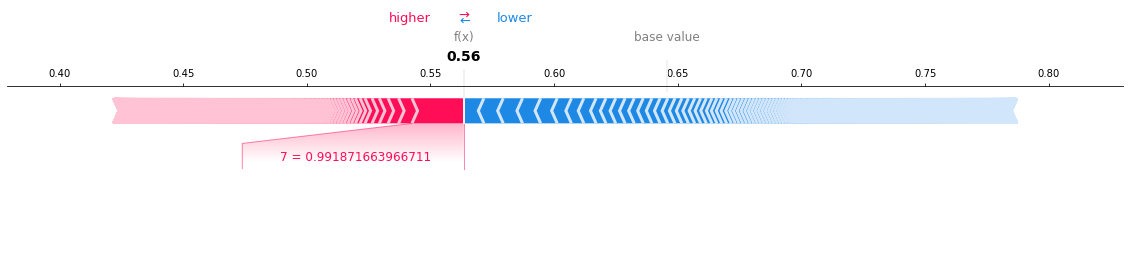

0.5634975562183783
0
The compound is predicted DILI-Negative
unbound Cmax:  7.35 uM
total Cmax:  12.78 uM
Most contributing MACCS substructure to DILI toxicity
Presence of this substructure contributes 0.0005 to prediction
Most contributing MACCS substructure to DILI safety
Presence of this substructure contributes -0.0012 to prediction


In [17]:
        test = {'smiles_r':  [smiles_r]
                    }
        test = pd.DataFrame(test)

        desc=pd.read_csv("all_features_desc.csv", encoding='windows-1252')


        molecule = Chem.MolFromSmiles(smiles_r)     
        #st.image(Draw.MolToImage(molecule), width=200)
                
        test_mfp_Mordred = calc_all_fp_desc(test)
        test_mfp_Mordred_liv = predict_liv_all(test_mfp_Mordred)
        test_mfp_Mordred_liv_values = test_mfp_Mordred_liv.T.reset_index().rename(columns={"index":"name", 0: "value"})

        interpret, y_proba, y_pred = predict_DILI(test_mfp_Mordred_liv)   
        interpret = pd.merge(interpret, desc, right_on="name", left_on="name", how="outer")
        interpret = pd.merge(interpret, test_mfp_Mordred_liv_values, right_on="name", left_on="name", how="inner") 

        print(y_proba[0])
        print(y_pred[0]) 
        
        if(y_pred[0]==1):
            print("The compound is predicted DILI-Positive")
        if(y_pred[0]==0):
            print("The compound is predicted DILI-Negative")
        
        print("unbound Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar unbound plasma concentration"][0] *10**6, 2), "uM")
        print("total Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar total plasma concentration"][0] *10**6, 2), "uM")
        print("Most contributing MACCS substructure to DILI toxicity")
        
        top = interpret[interpret["SHAP"]>0].sort_values(by=["SHAP"], ascending=False)
        proxy_DILI_SHAP_top = pd.merge(info, top[top["name"].isin(liv_data)])
        proxy_DILI_SHAP_top["pred"] = proxy_DILI_SHAP_top["value"]>0.50
        proxy_DILI_SHAP_top["SHAP contribution to Toxicity"] = "Positive"
        proxy_DILI_SHAP_top["smiles"] = smiles_r
        
        top_positives = top[top["value"]==1]
        top_MACCS= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
        top_MACCS_value= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
        top_MACCS_shap= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0] 
        top_MACCSsubstructure = Chem.MolFromSmarts(top_MACCS)
        
        Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(top_MACCSsubstructure), width=400)        
        print("Presence of this substructure contributes", np.round(top_MACCS_shap, 4), "to prediction")
                     
                 
        print("Most contributing MACCS substructure to DILI safety")
        bottom = interpret[interpret["SHAP"]<0].sort_values(by=["SHAP"], ascending=True)
        proxy_DILI_SHAP_bottom = pd.merge(info, bottom[bottom["name"].isin(liv_data)])
        proxy_DILI_SHAP_bottom["pred"] = proxy_DILI_SHAP_bottom["value"]>0.50
        proxy_DILI_SHAP_bottom["SHAP contribution to Toxicity"] = "Negative"
        proxy_DILI_SHAP_bottom["smiles"] = smiles_r
        
        bottom_positives = bottom[bottom["value"]==1]
        bottom_MACCS= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
        bottom_MACCS_value= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
        bottom_MACCS_shap= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0]     
        bottom_MACCSsubstructure = Chem.MolFromSmarts(bottom_MACCS)
                 
                                  
        Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(bottom_MACCSsubstructure), width=400) 
        print("Presence of this substructure contributes", np.round(bottom_MACCS_shap, 4), "to prediction")

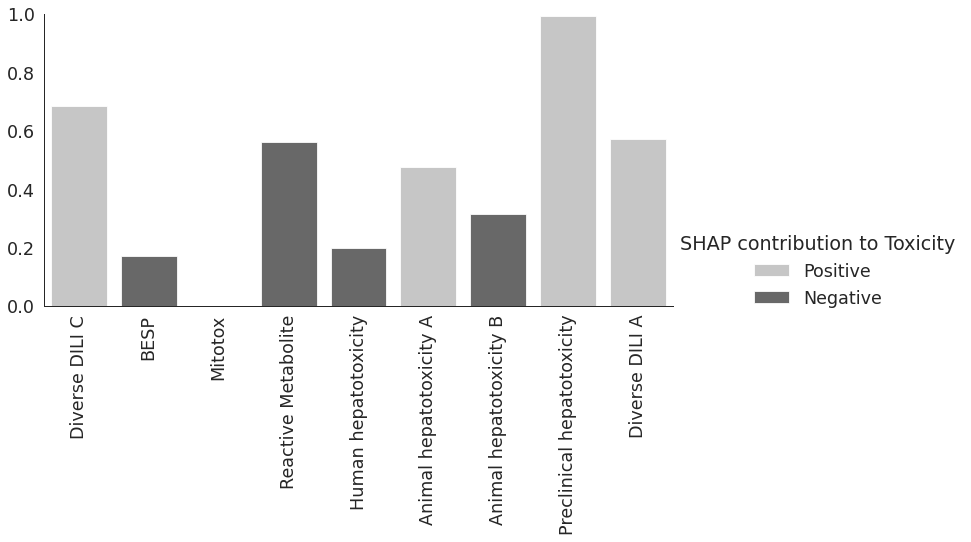

In [18]:
import seaborn as sns
SHAP =pd.DataFrame(columns=['name', 'source', 'assaytype', 'SHAP', 'description', 'value', 'pred','influence', 'smiles'])
SHAP = pd.concat([SHAP, proxy_DILI_SHAP_top])
SHAP = pd.concat([SHAP, proxy_DILI_SHAP_bottom])
SHAP["name"] = SHAP["name"].astype(str)
SHAP = SHAP.sort_values(by=["name"], ascending=True)
#fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.set_style('white')
sns.set_context('paper', font_scale=2)
hue_order = ['Positive', 'Negative']
#sns.barplot(data=compound, x="source", y="value", color='grey')
g = sns.catplot(data=SHAP, x="source", y="value", kind="bar", hue_order=hue_order,  hue="SHAP contribution to Toxicity",  
                palette="Greys", height=5, aspect=2, dodge=False, legend=True)
#plt.axhline(y=0.5, color='r', linestyle='--')
g.set_xticklabels(rotation=90)
g.set(ylabel=None)
g.set(xlabel=None)
g.set(ylim=(0, 1))
plt.show()

In [19]:
SHAP

,name,source,assaytype,SHAP,description,value,pred,influence,smiles,SHAP contribution to Toxicity
3,11,Diverse DILI C,Heterogenous Data,0.004235,"Transient liver function abnormalities, advers...",0.683299,True,NaN,CCCCOCCO,Positive
2,14,BESP,Mechanisms of Liver Toxicity,-0.000216,BESP Bile Salt Export Pump Inhibition,0.172278,False,NaN,CCCCOCCO,Negative
3,15,Mitotox,Mechanisms of Liver Toxicity,-0.008084,Mitotox,0.00126,False,NaN,CCCCOCCO,Negative
4,16,Reactive Metabolite,Mechanisms of Liver Toxicity,-0.000719,Reactive Metabolite Formation,0.561835,True,NaN,CCCCOCCO,Negative
0,3,Human hepatotoxicity,Human hepatotoxicity,-0.006702,"Human hepatotoxicity, hepatobiallry",0.199695,False,NaN,CCCCOCCO,Negative
0,5,Animal hepatotoxicity A,Animal hepatotoxicity,0.002946,"Rat, chronic oral administration, Hepatic hist...",0.474123,False,NaN,CCCCOCCO,Positive
1,6,Animal hepatotoxicity B,Animal hepatotoxicity,-0.001956,"Hepatocellular hypertrophy, rats, ORAD, HESS",0.313287,False,NaN,CCCCOCCO,Negative
1,7,Preclinical hepatotoxicity,Animal hepatotoxicity,0.020985,Preclinical hepatotoxicity data from PharmaPen...,0.991872,True,NaN,CCCCOCCO,Positive
2,8,Diverse DILI A,Heterogenous Data,0.005413,Large-scale and diverse ddrug induced liver in...,0.571555,True,NaN,CCCCOCCO,Positive


In [20]:
SHAP

,name,source,assaytype,SHAP,description,value,pred,influence,smiles,SHAP contribution to Toxicity
3,11,Diverse DILI C,Heterogenous Data,0.004235,"Transient liver function abnormalities, advers...",0.683299,True,NaN,CCCCOCCO,Positive
2,14,BESP,Mechanisms of Liver Toxicity,-0.000216,BESP Bile Salt Export Pump Inhibition,0.172278,False,NaN,CCCCOCCO,Negative
3,15,Mitotox,Mechanisms of Liver Toxicity,-0.008084,Mitotox,0.00126,False,NaN,CCCCOCCO,Negative
4,16,Reactive Metabolite,Mechanisms of Liver Toxicity,-0.000719,Reactive Metabolite Formation,0.561835,True,NaN,CCCCOCCO,Negative
0,3,Human hepatotoxicity,Human hepatotoxicity,-0.006702,"Human hepatotoxicity, hepatobiallry",0.199695,False,NaN,CCCCOCCO,Negative
0,5,Animal hepatotoxicity A,Animal hepatotoxicity,0.002946,"Rat, chronic oral administration, Hepatic hist...",0.474123,False,NaN,CCCCOCCO,Positive
1,6,Animal hepatotoxicity B,Animal hepatotoxicity,-0.001956,"Hepatocellular hypertrophy, rats, ORAD, HESS",0.313287,False,NaN,CCCCOCCO,Negative
1,7,Preclinical hepatotoxicity,Animal hepatotoxicity,0.020985,Preclinical hepatotoxicity data from PharmaPen...,0.991872,True,NaN,CCCCOCCO,Positive
2,8,Diverse DILI A,Heterogenous Data,0.005413,Large-scale and diverse ddrug induced liver in...,0.571555,True,NaN,CCCCOCCO,Positive


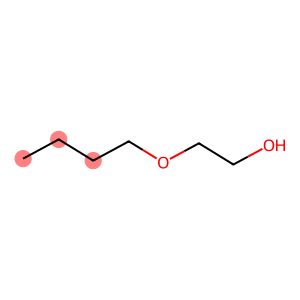

In [21]:
Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(top_MACCSsubstructure), width=40)

In [22]:
test_mfp_Mordred_liv

,smiles_r,Mfp0,Mfp1,Mfp2,Mfp3,Mfp4,Mfp5,Mfp6,Mfp7,Mfp8,...,5,6,7,8,11,14,15,16,median pMolar unbound plasma concentration,median pMolar total plasma concentration
0,CCCCOCCO,0,0,0,0,0,0,0,0,0,...,0.474123,0.313287,0.991872,0.571555,0.683299,0.172278,0.00126,0.561835,5.133441,4.893612


In [23]:
test_mfp_Mordred_liv_values

,name,value
0,smiles_r,CCCCOCCO
1,Mfp0,0
2,Mfp1,0
3,Mfp2,0
4,Mfp3,0
...,...,...
3850,14,0.172278
3851,15,0.00126
3852,16,0.561835
3853,median pMolar unbound plasma concentration,5.133441


In [24]:
smiles_list = literature.smiles_r.to_list()
smiles_list

['CCCCOCCO',
 'CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=C(C)C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C',
 'CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C2(C)C)cc1F',
 'Cc1cc2c(cc1CC(=O)c1sccc1S(=O)(=O)N=c1o[nH]c(C)c1Cl)OCO2']

In [25]:
names= literature.name.to_list()
names

['2-Butoxyethanol', 'Astaxanthin', 'Enzalutamide', 'Sitaxentan']

In [26]:
for name in names:
    print(name)

2-Butoxyethanol
Astaxanthin
Enzalutamide
Sitaxentan


CCCCOCCO
2-Butoxyethanol
1613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Best Threshold=0.612911


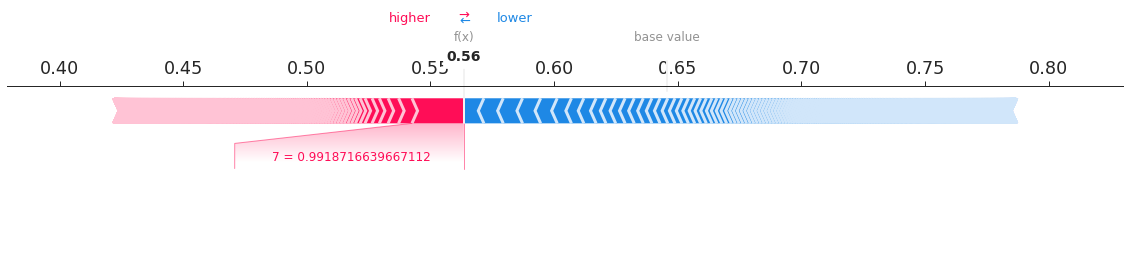

0.5634975562183782
0
Negative
unbound Cmax:  7.35 uM
total Cmax:  12.78 uM
Most contributing MACCS substructure to DILI toxicity
[CH3]~[CH2]~*
*~[CH2]~[!#6;!#1;!H0]
CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=C(C)C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C
Astaxanthin
1613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Best Threshold=0.612911


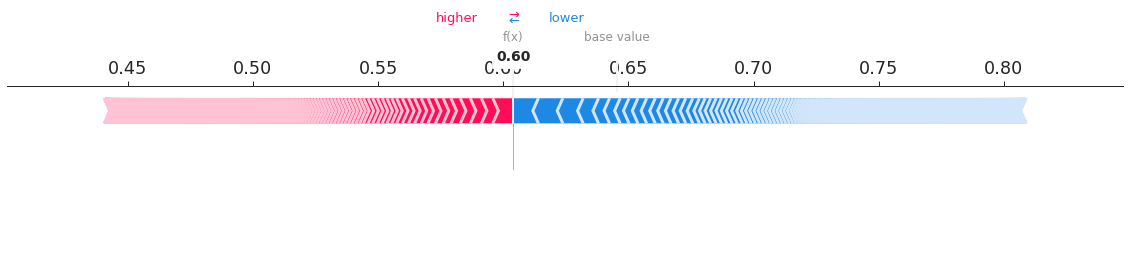

0.6040300041561754
0
Negative
unbound Cmax:  0.02 uM
total Cmax:  1.57 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
*~*(~*)(~*)~*
CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C2(C)C)cc1F
Enzalutamide
1613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Best Threshold=0.612911


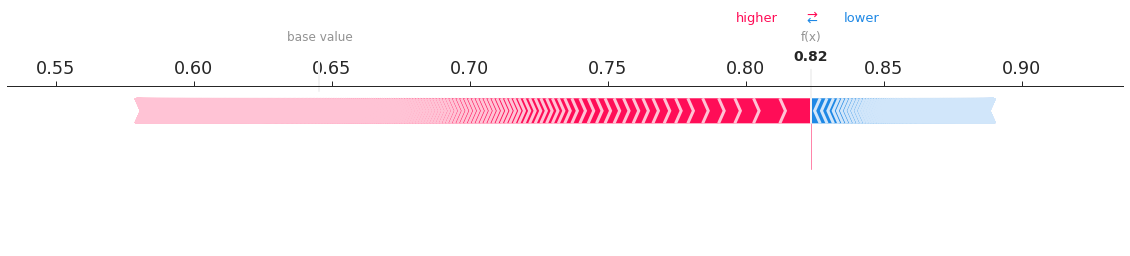

0.8235472758927437
1
Positive
unbound Cmax:  0.18 uM
total Cmax:  8.02 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
[!#6;!#1]~*(~[!#6;!#1])~[!#6;!#1]
Cc1cc2c(cc1CC(=O)c1sccc1S(=O)(=O)N=c1o[nH]c(C)c1Cl)OCO2
Sitaxentan
1613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


Best Threshold=0.612911


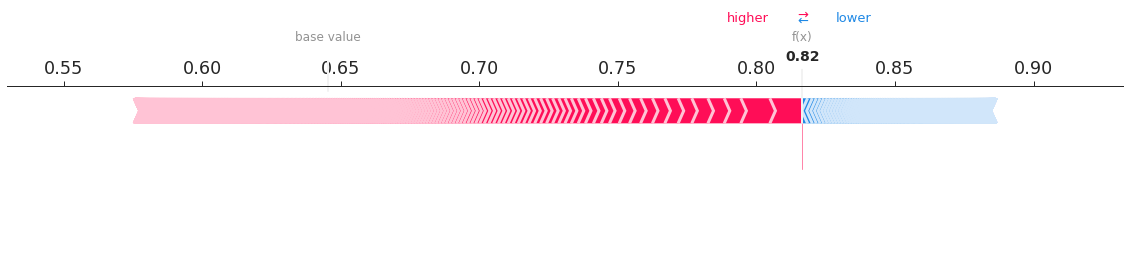

0.8165696827956019
1
Positive
unbound Cmax:  0.32 uM
total Cmax:  7.97 uM
Most contributing MACCS substructure to DILI toxicity
*@*!@[#7]
[!#6;!#1]~[CH2]~*


In [27]:
list_of_lists=[]
SHAP =pd.DataFrame(columns=['name', 'source', 'assaytype', 'SHAP', 'description', 'value', 'pred','influence', 'smiles'])

for s, n in zip(smiles_list, names):  
    
    print(s)
    print(n)
    smiles = unquote(s)
    
    smiles_r = standardized_smiles(smiles)
    test = {'smiles_r':  [smiles_r]
                }
    test = pd.DataFrame(test)
    
    test_mfp_Mordred = calc_all_fp_desc(test)
    
    test_mfp_Mordred_liv = predict_liv_all(test_mfp_Mordred)
    test_mfp_Mordred_liv_values = test_mfp_Mordred_liv.T.reset_index().rename(columns={"index":"name", 0: "value"})
    
    desc=pd.read_csv("all_features_desc.csv", encoding='windows-1252')

    interpret, y_proba, y_pred = predict_DILI(test_mfp_Mordred_liv)   
    interpret = pd.merge(interpret, desc, right_on="name", left_on="name", how="outer")
    interpret = pd.merge(interpret, test_mfp_Mordred_liv_values, right_on="name", left_on="name", how="inner") 

    print(y_proba[0])
    print(y_pred[0])
    
    if(y_pred[0] == 0):
        print("Negative")
    else:
        print("Positive")
        
    print("unbound Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar unbound plasma concentration"][0] *10**6, 2), "uM")
    print("total Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar total plasma concentration"][0] *10**6, 2), "uM")
    print("Most contributing MACCS substructure to DILI toxicity")
        
    top = interpret[interpret["SHAP"]>0].sort_values(by=["SHAP"], ascending=False)#.reset_index(drop=True)
    proxy_DILI_SHAP_top = pd.merge(info, top[top["name"].isin(liv_data)])
    proxy_DILI_SHAP_top["pred"] = proxy_DILI_SHAP_top["value"]>0.50
    proxy_DILI_SHAP_top["SHAP contribution to Toxicity"] = "Positive"
    proxy_DILI_SHAP_top["smiles"] = s
    proxy_DILI_SHAP_top["compound"] = n
    
    top_positives = top[top["value"]==1]
    top_MACCS= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
    print(top_MACCS)
    
    bottom = interpret[interpret["SHAP"]<0].sort_values(by=["SHAP"], ascending=True)#.reset_index(drop=True)
    proxy_DILI_SHAP_bottom = pd.merge(info, bottom[bottom["name"].isin(liv_data)])
    proxy_DILI_SHAP_bottom["pred"] = proxy_DILI_SHAP_bottom["value"]>0.50
    proxy_DILI_SHAP_bottom["SHAP contribution to Toxicity"] = "Negative"
    proxy_DILI_SHAP_bottom["smiles"] = s
    proxy_DILI_SHAP_bottom["compound"] = n
    
    bottom_positives = bottom[bottom["value"]==1]
    bottom_MACCS= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
    print(bottom_MACCS)
    
    SHAP = pd.concat([SHAP, proxy_DILI_SHAP_top])
    SHAP = pd.concat([SHAP, proxy_DILI_SHAP_bottom])
    
    
    row=[s, n, top_MACCS, bottom_MACCS]
    list_of_lists.append(row)
    

In [28]:
top

,name,SHAP,description,value
862,7,1.170469e-02,Preclinical hepatotoxicity data from PharmaPen...,0.944095
859,3,1.047872e-02,"Human hepatotoxicity, hepatobiallry",0.818639
492,MIC5,5.995539e-03,5-ordered modified information content,55.407967
866,15,5.889788e-03,Mitotox,0.295087
124,AATS0v,5.807162e-03,NaN,263.001337
...,...,...,...,...
582,bpol,3.162279e-06,NaN,31.320105
613,SMR,2.876381e-06,Wildman-Crippen MR,105.21
823,MACCS147,2.382225e-06,"[$(*~[CH2]~[CH2]~*),$([R]1@[CH2;R]@[CH2;R]1)]",0
428,SsNH2,1.563562e-06,sum of sNH2,0.0


In [29]:
SHAP["name"] = SHAP["name"].astype(int)
SHAP

,name,source,assaytype,SHAP,description,value,pred,influence,smiles,SHAP contribution to Toxicity,compound
0,5,Animal hepatotoxicity A,Animal hepatotoxicity,0.002946,"Rat, chronic oral administration, Hepatic hist...",0.474123,False,NaN,CCCCOCCO,Positive,2-Butoxyethanol
1,7,Preclinical hepatotoxicity,Animal hepatotoxicity,0.020985,Preclinical hepatotoxicity data from PharmaPen...,0.991872,True,NaN,CCCCOCCO,Positive,2-Butoxyethanol
2,8,Diverse DILI A,Heterogenous Data,0.005413,Large-scale and diverse ddrug induced liver in...,0.571555,True,NaN,CCCCOCCO,Positive,2-Butoxyethanol
3,11,Diverse DILI C,Heterogenous Data,0.004235,"Transient liver function abnormalities, advers...",0.683299,True,NaN,CCCCOCCO,Positive,2-Butoxyethanol
0,3,Human hepatotoxicity,Human hepatotoxicity,-0.006702,"Human hepatotoxicity, hepatobiallry",0.199695,False,NaN,CCCCOCCO,Negative,2-Butoxyethanol
1,6,Animal hepatotoxicity B,Animal hepatotoxicity,-0.001956,"Hepatocellular hypertrophy, rats, ORAD, HESS",0.313287,False,NaN,CCCCOCCO,Negative,2-Butoxyethanol
2,14,BESP,Mechanisms of Liver Toxicity,-0.000216,BESP Bile Salt Export Pump Inhibition,0.172278,False,NaN,CCCCOCCO,Negative,2-Butoxyethanol
3,15,Mitotox,Mechanisms of Liver Toxicity,-0.008084,Mitotox,0.00126,False,NaN,CCCCOCCO,Negative,2-Butoxyethanol
4,16,Reactive Metabolite,Mechanisms of Liver Toxicity,-0.000719,Reactive Metabolite Formation,0.561835,True,NaN,CCCCOCCO,Negative,2-Butoxyethanol
0,14,BESP,Mechanisms of Liver Toxicity,0.000208,BESP Bile Salt Export Pump Inhibition,0.752681,True,NaN,CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=...,Positive,Astaxanthin


In [30]:
SHAP.to_csv("./SHAP_molecules/SHAP_molecules.csv", index=False)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


2-Butoxyethanol
9


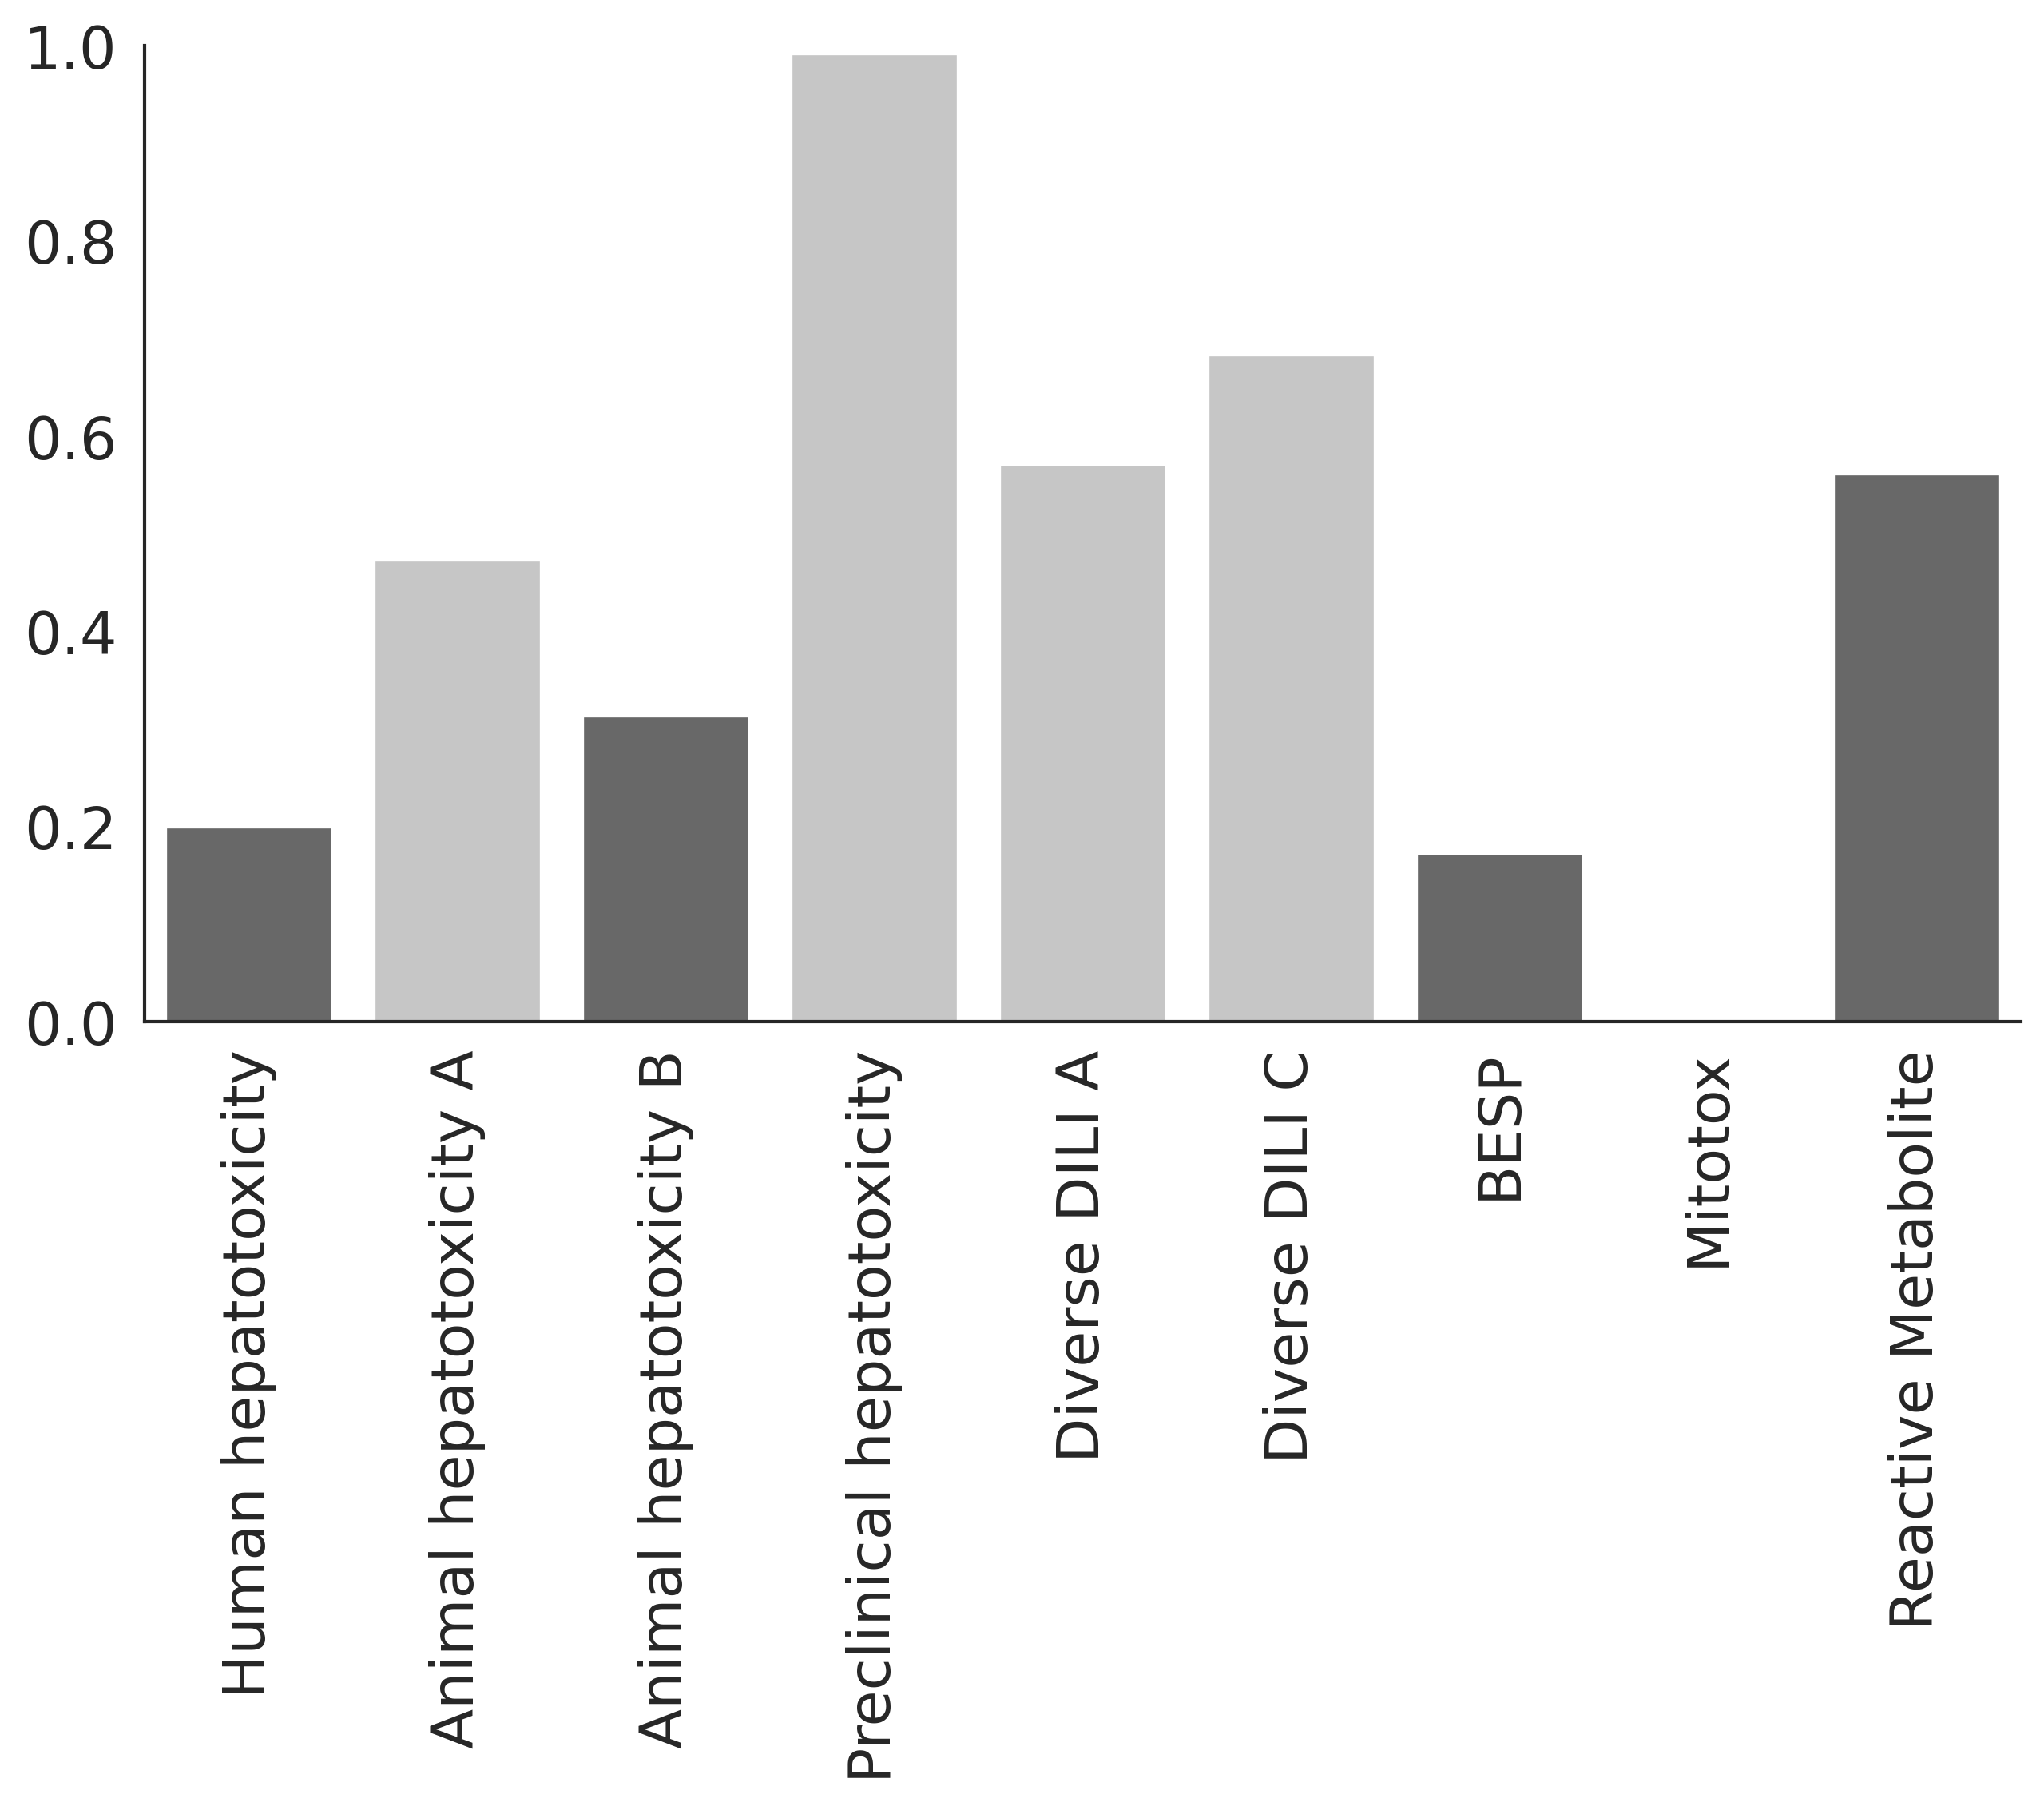

Astaxanthin
9


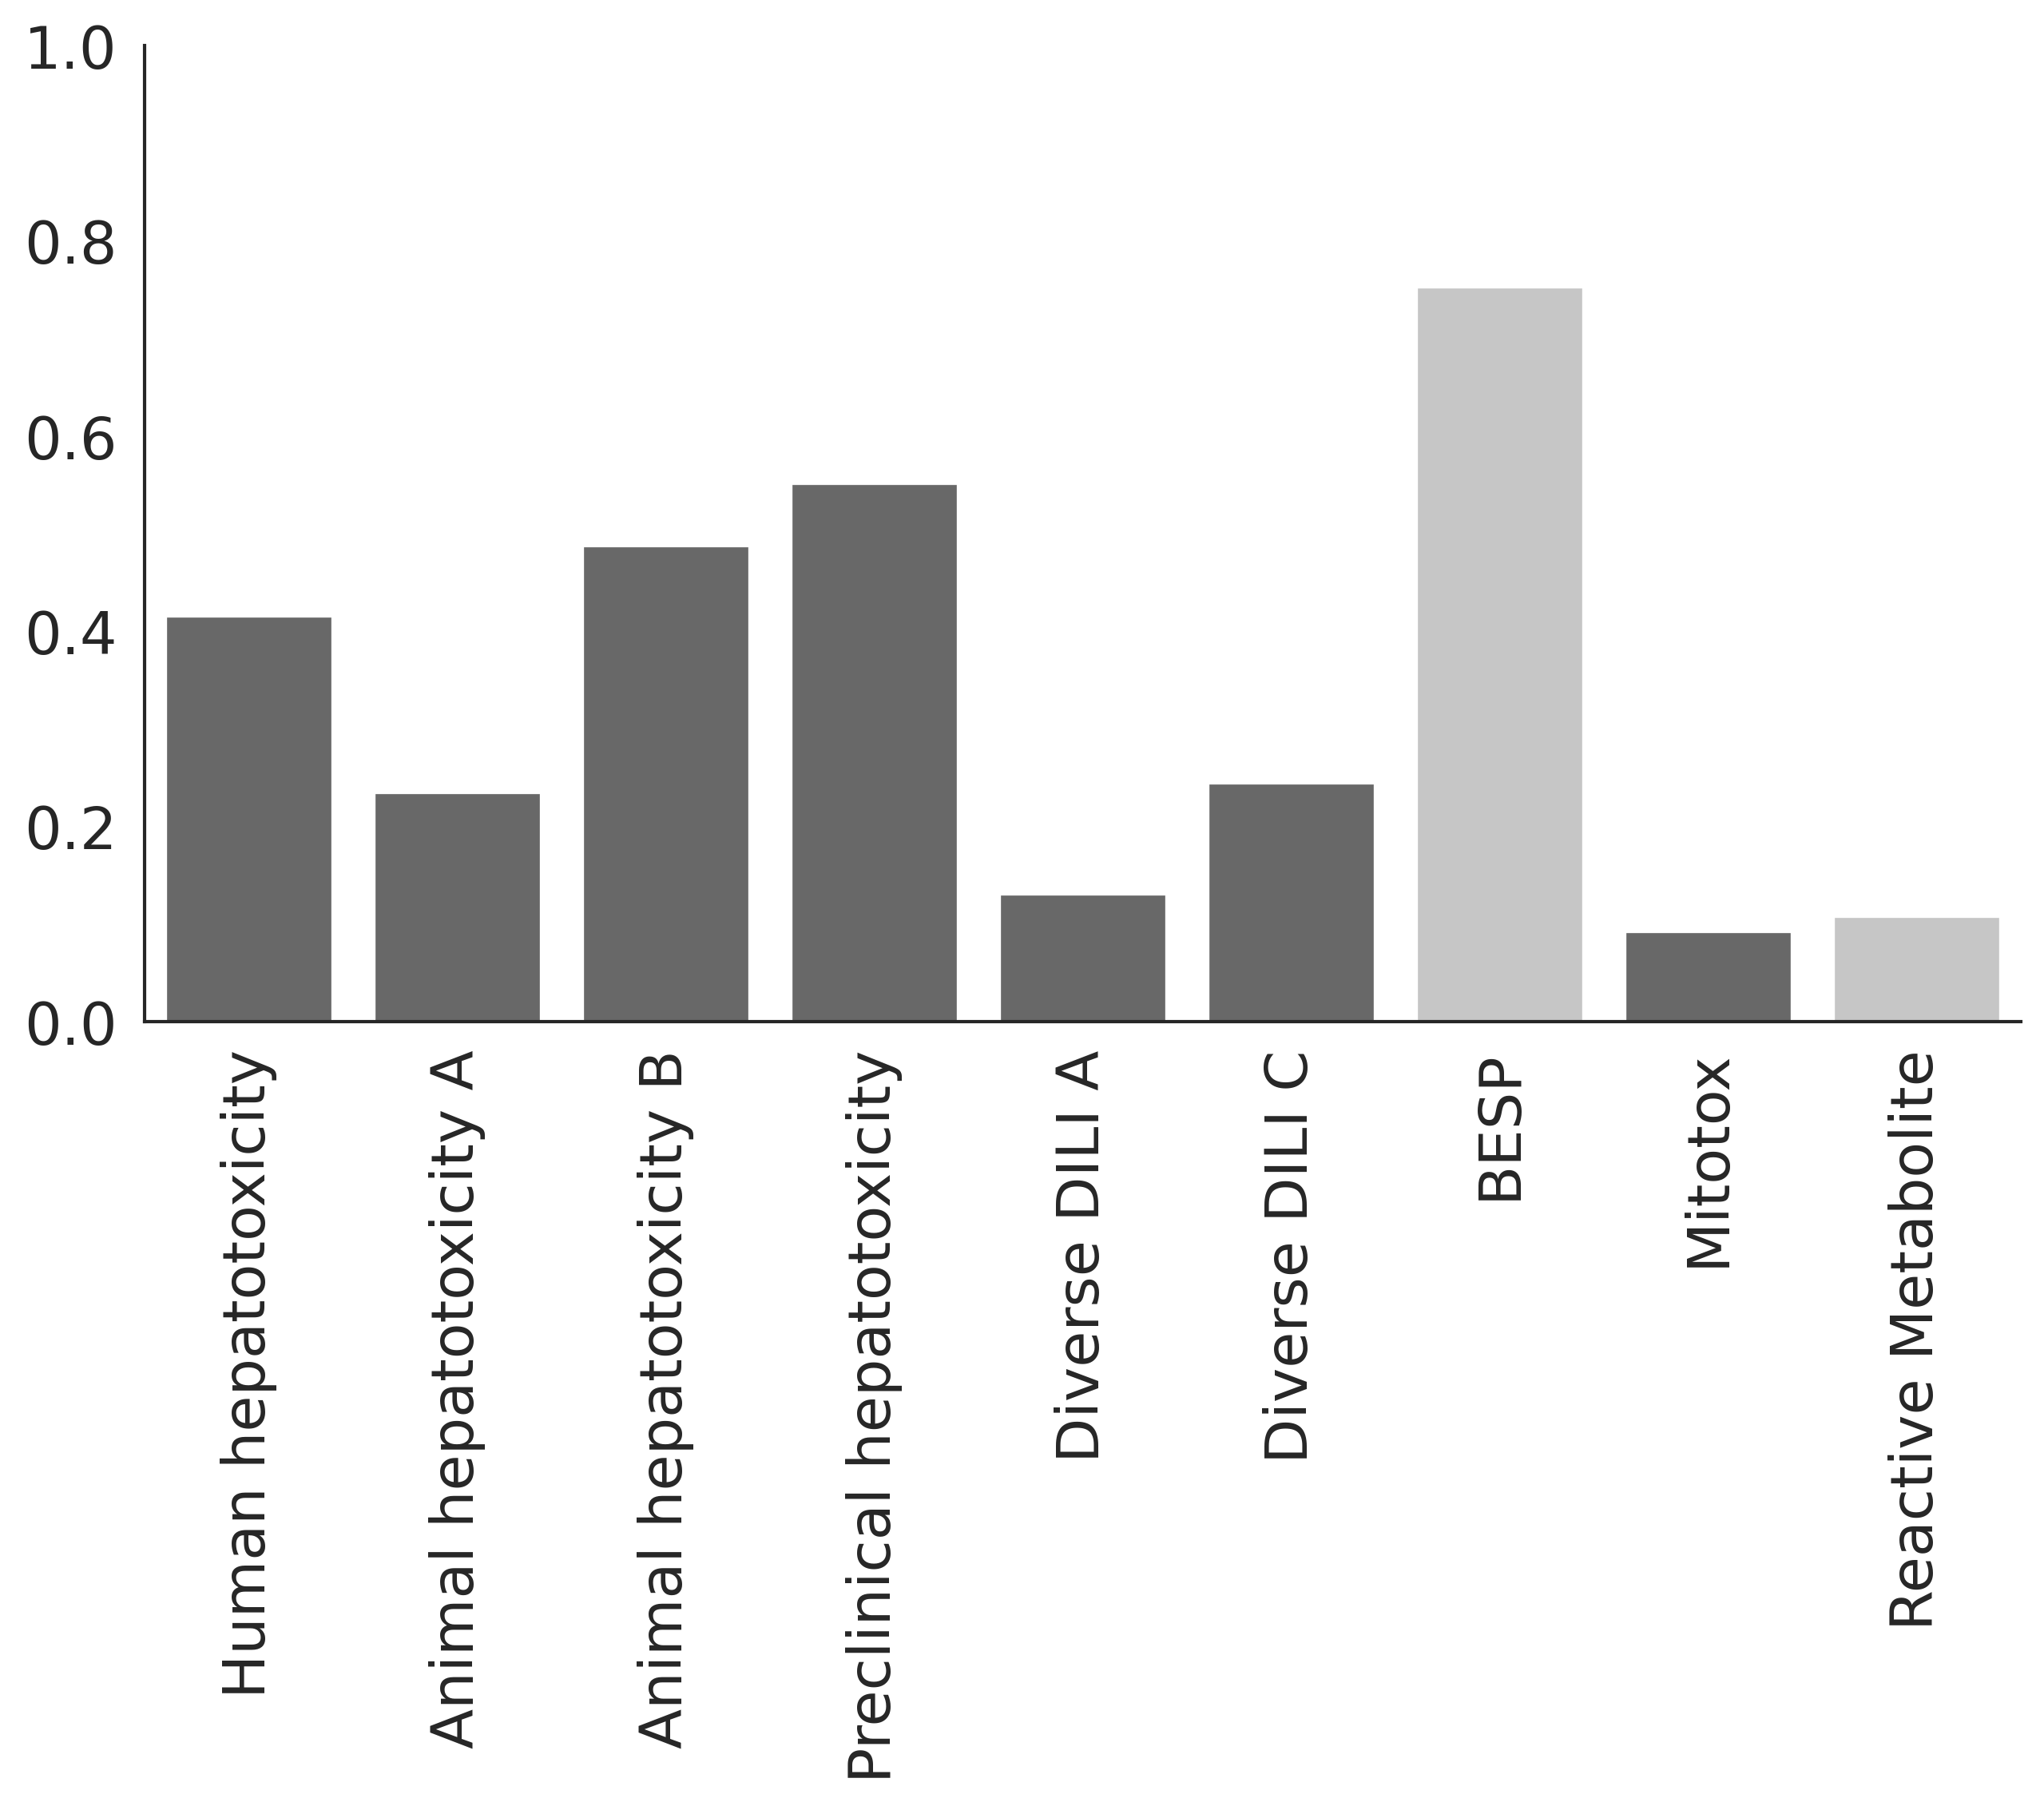

Enzalutamide
9


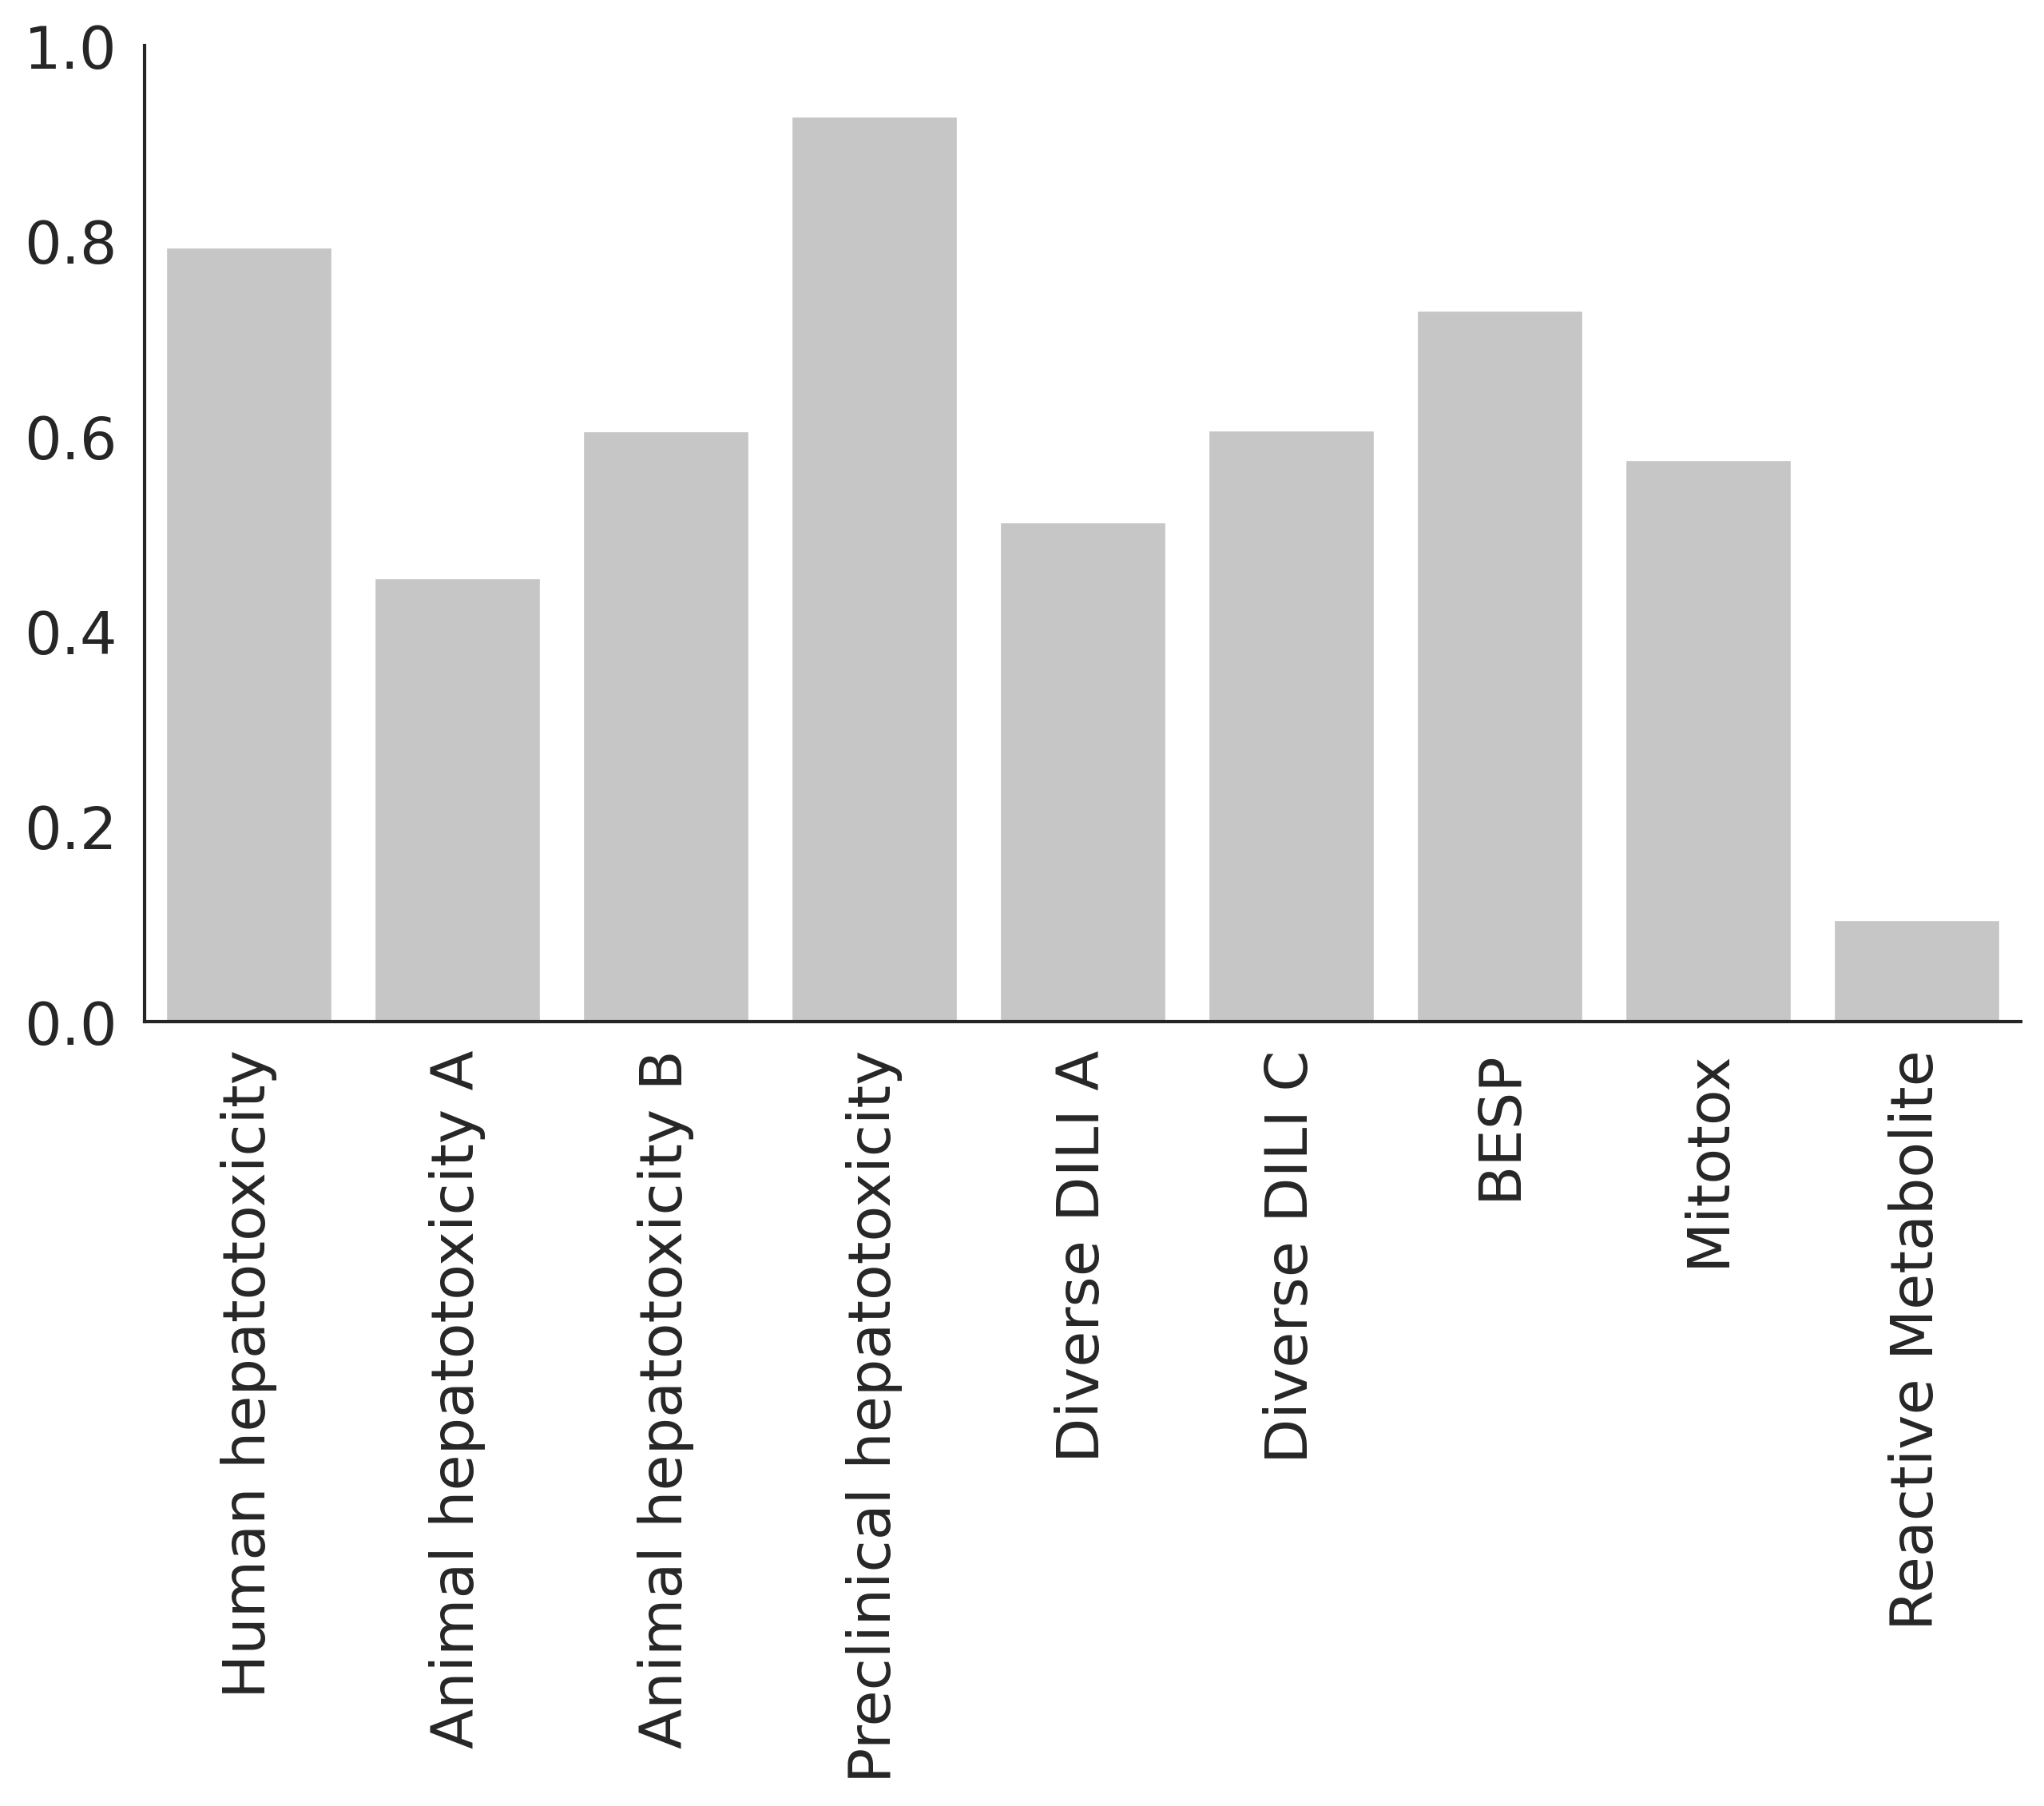

Sitaxentan
9


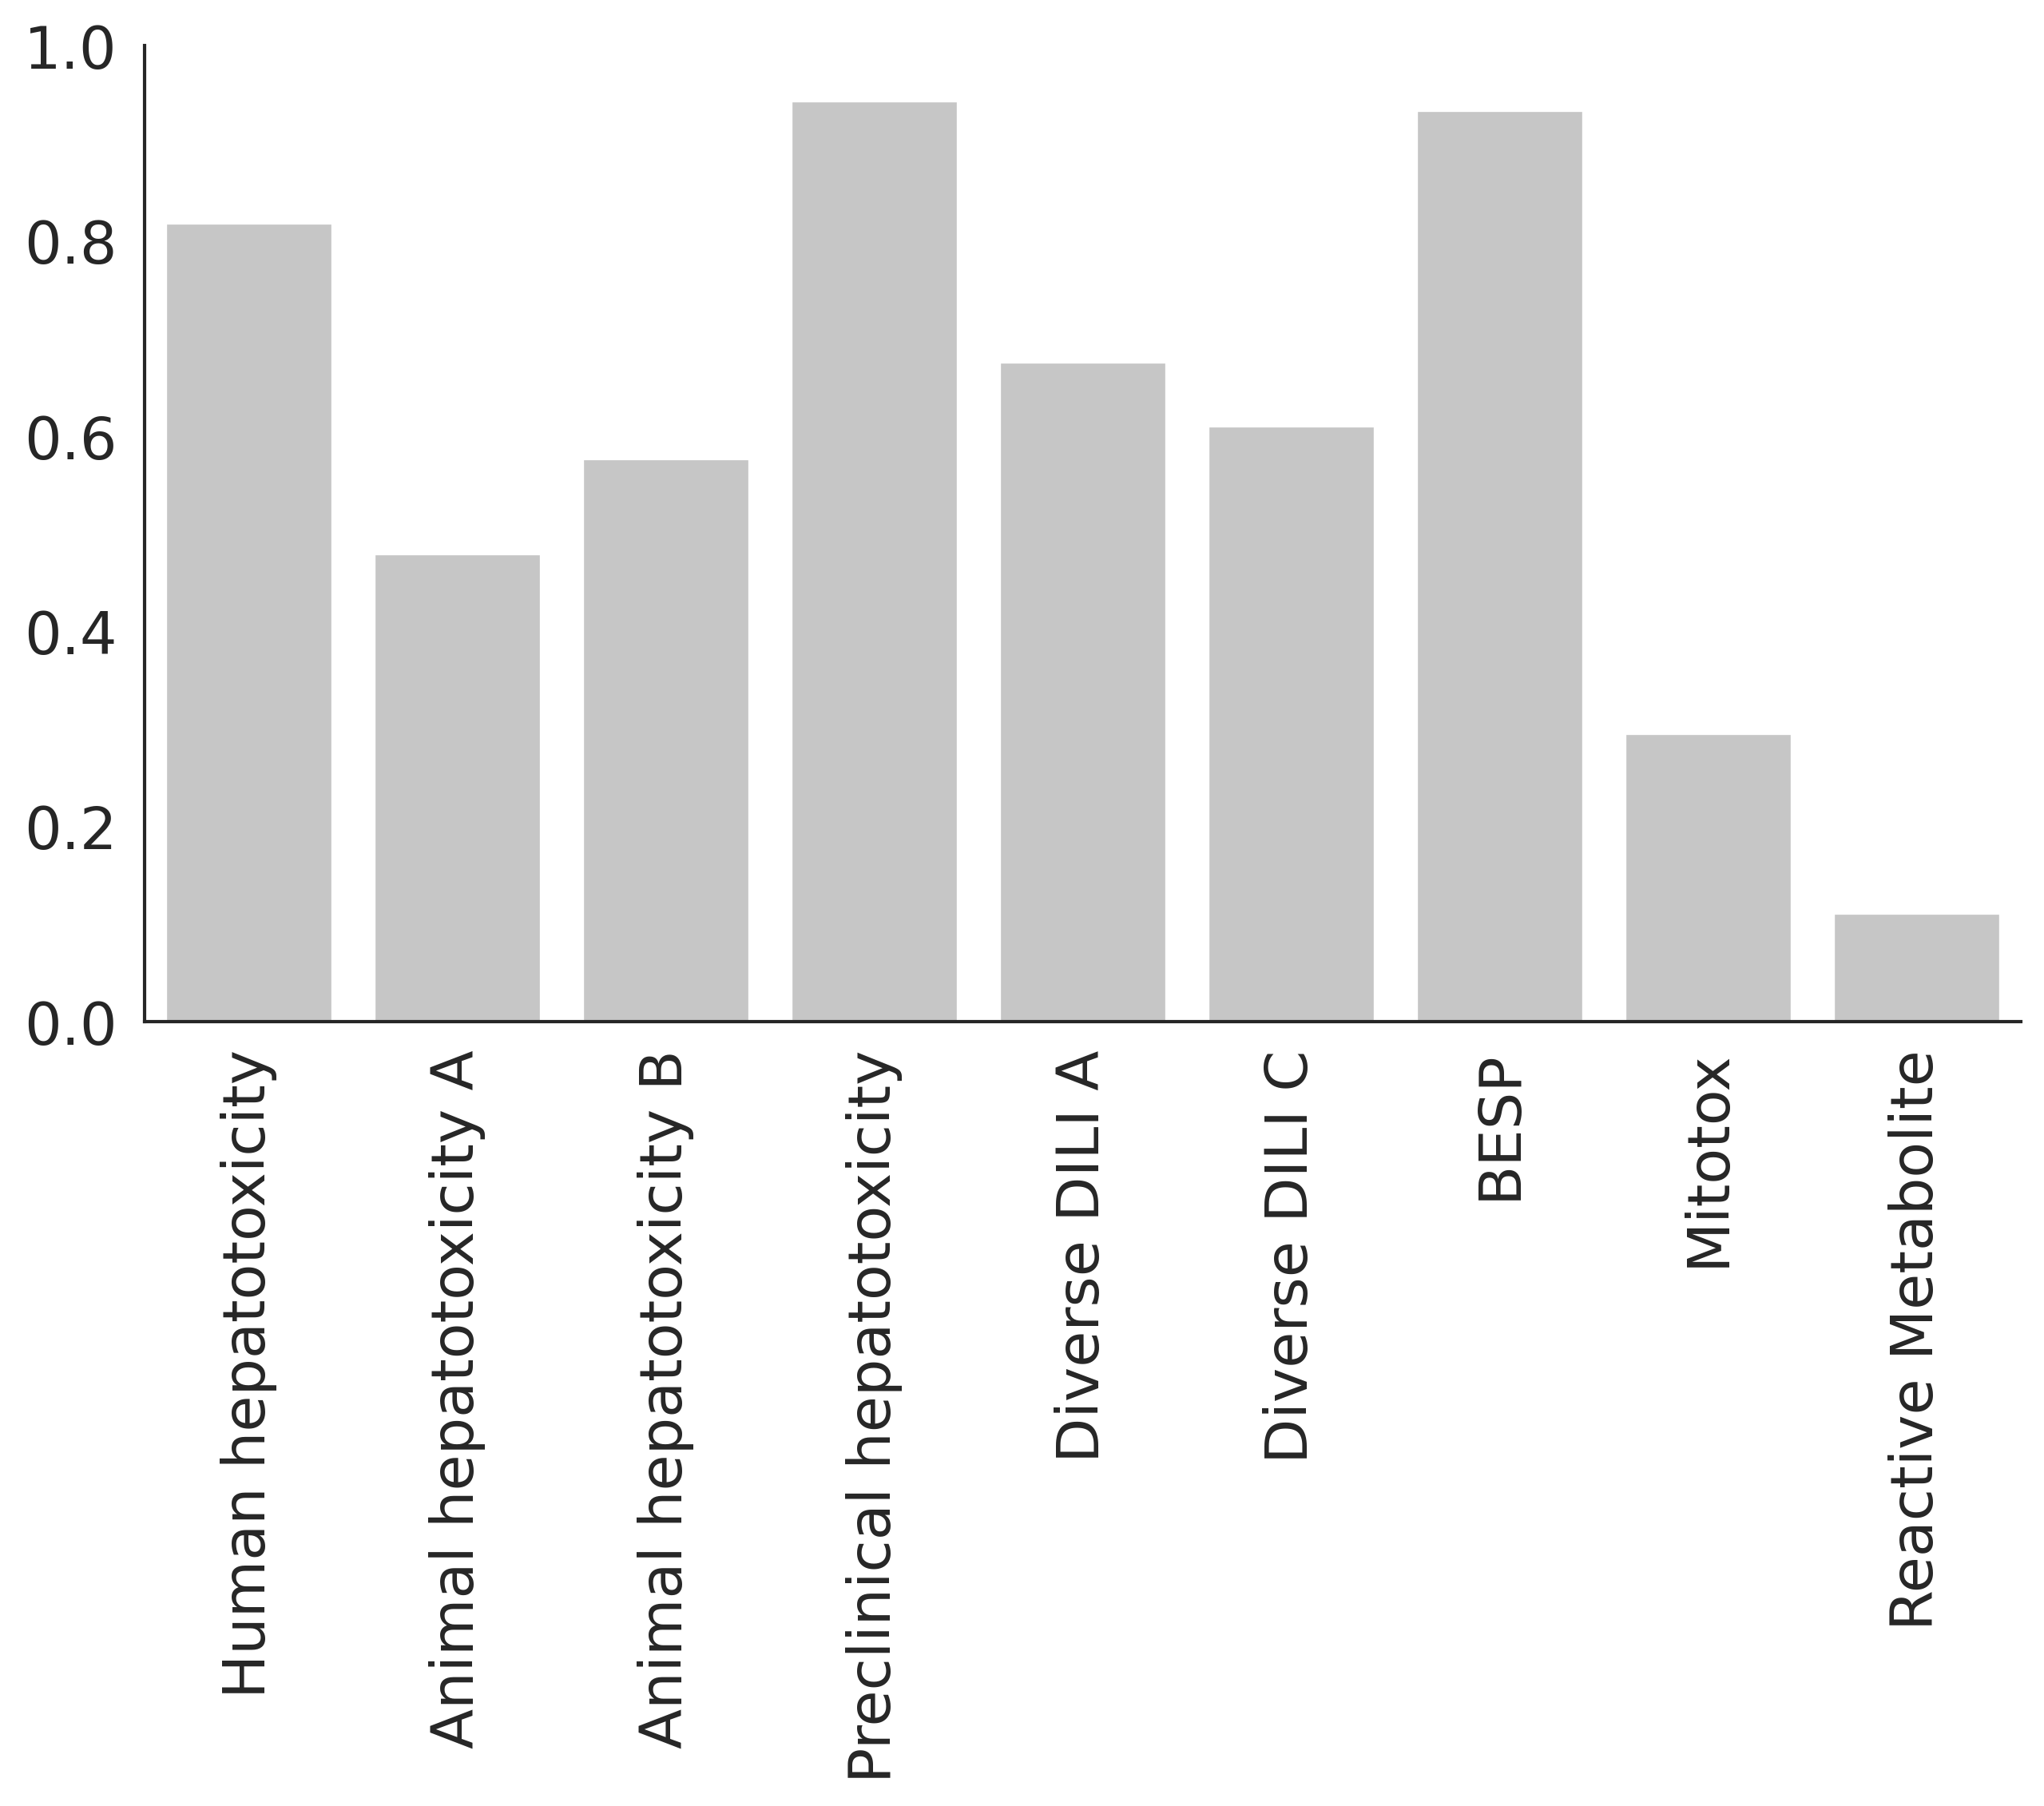

In [32]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

for compound_name in SHAP.compound.unique():
    print(compound_name)
    
    compound = SHAP[SHAP["compound"]==compound_name].sort_values(by=["name"], ascending=True)
    print(len(compound))
    

    #fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    sns.set_style('white')
    sns.set_context('paper', font_scale=2)
    hue_order = ['Positive', 'Negative']
    #sns.barplot(data=compound, x="source", y="value", color='grey')
    g = sns.catplot(data=compound, x="source", y="value", kind="bar",hue_order=hue_order,  hue="SHAP contribution to Toxicity",  
                    palette="Greys", 
                    height=5, aspect=2, dodge=False, legend=False)
    #plt.axhline(y=0.5, color='r', linestyle='--')
    g.set_xticklabels(rotation=90)
    g.set(ylabel=None)
    g.set(xlabel=None)
    g.set(ylim=(0, 1))
    plt.show()

2-Butoxyethanol
9


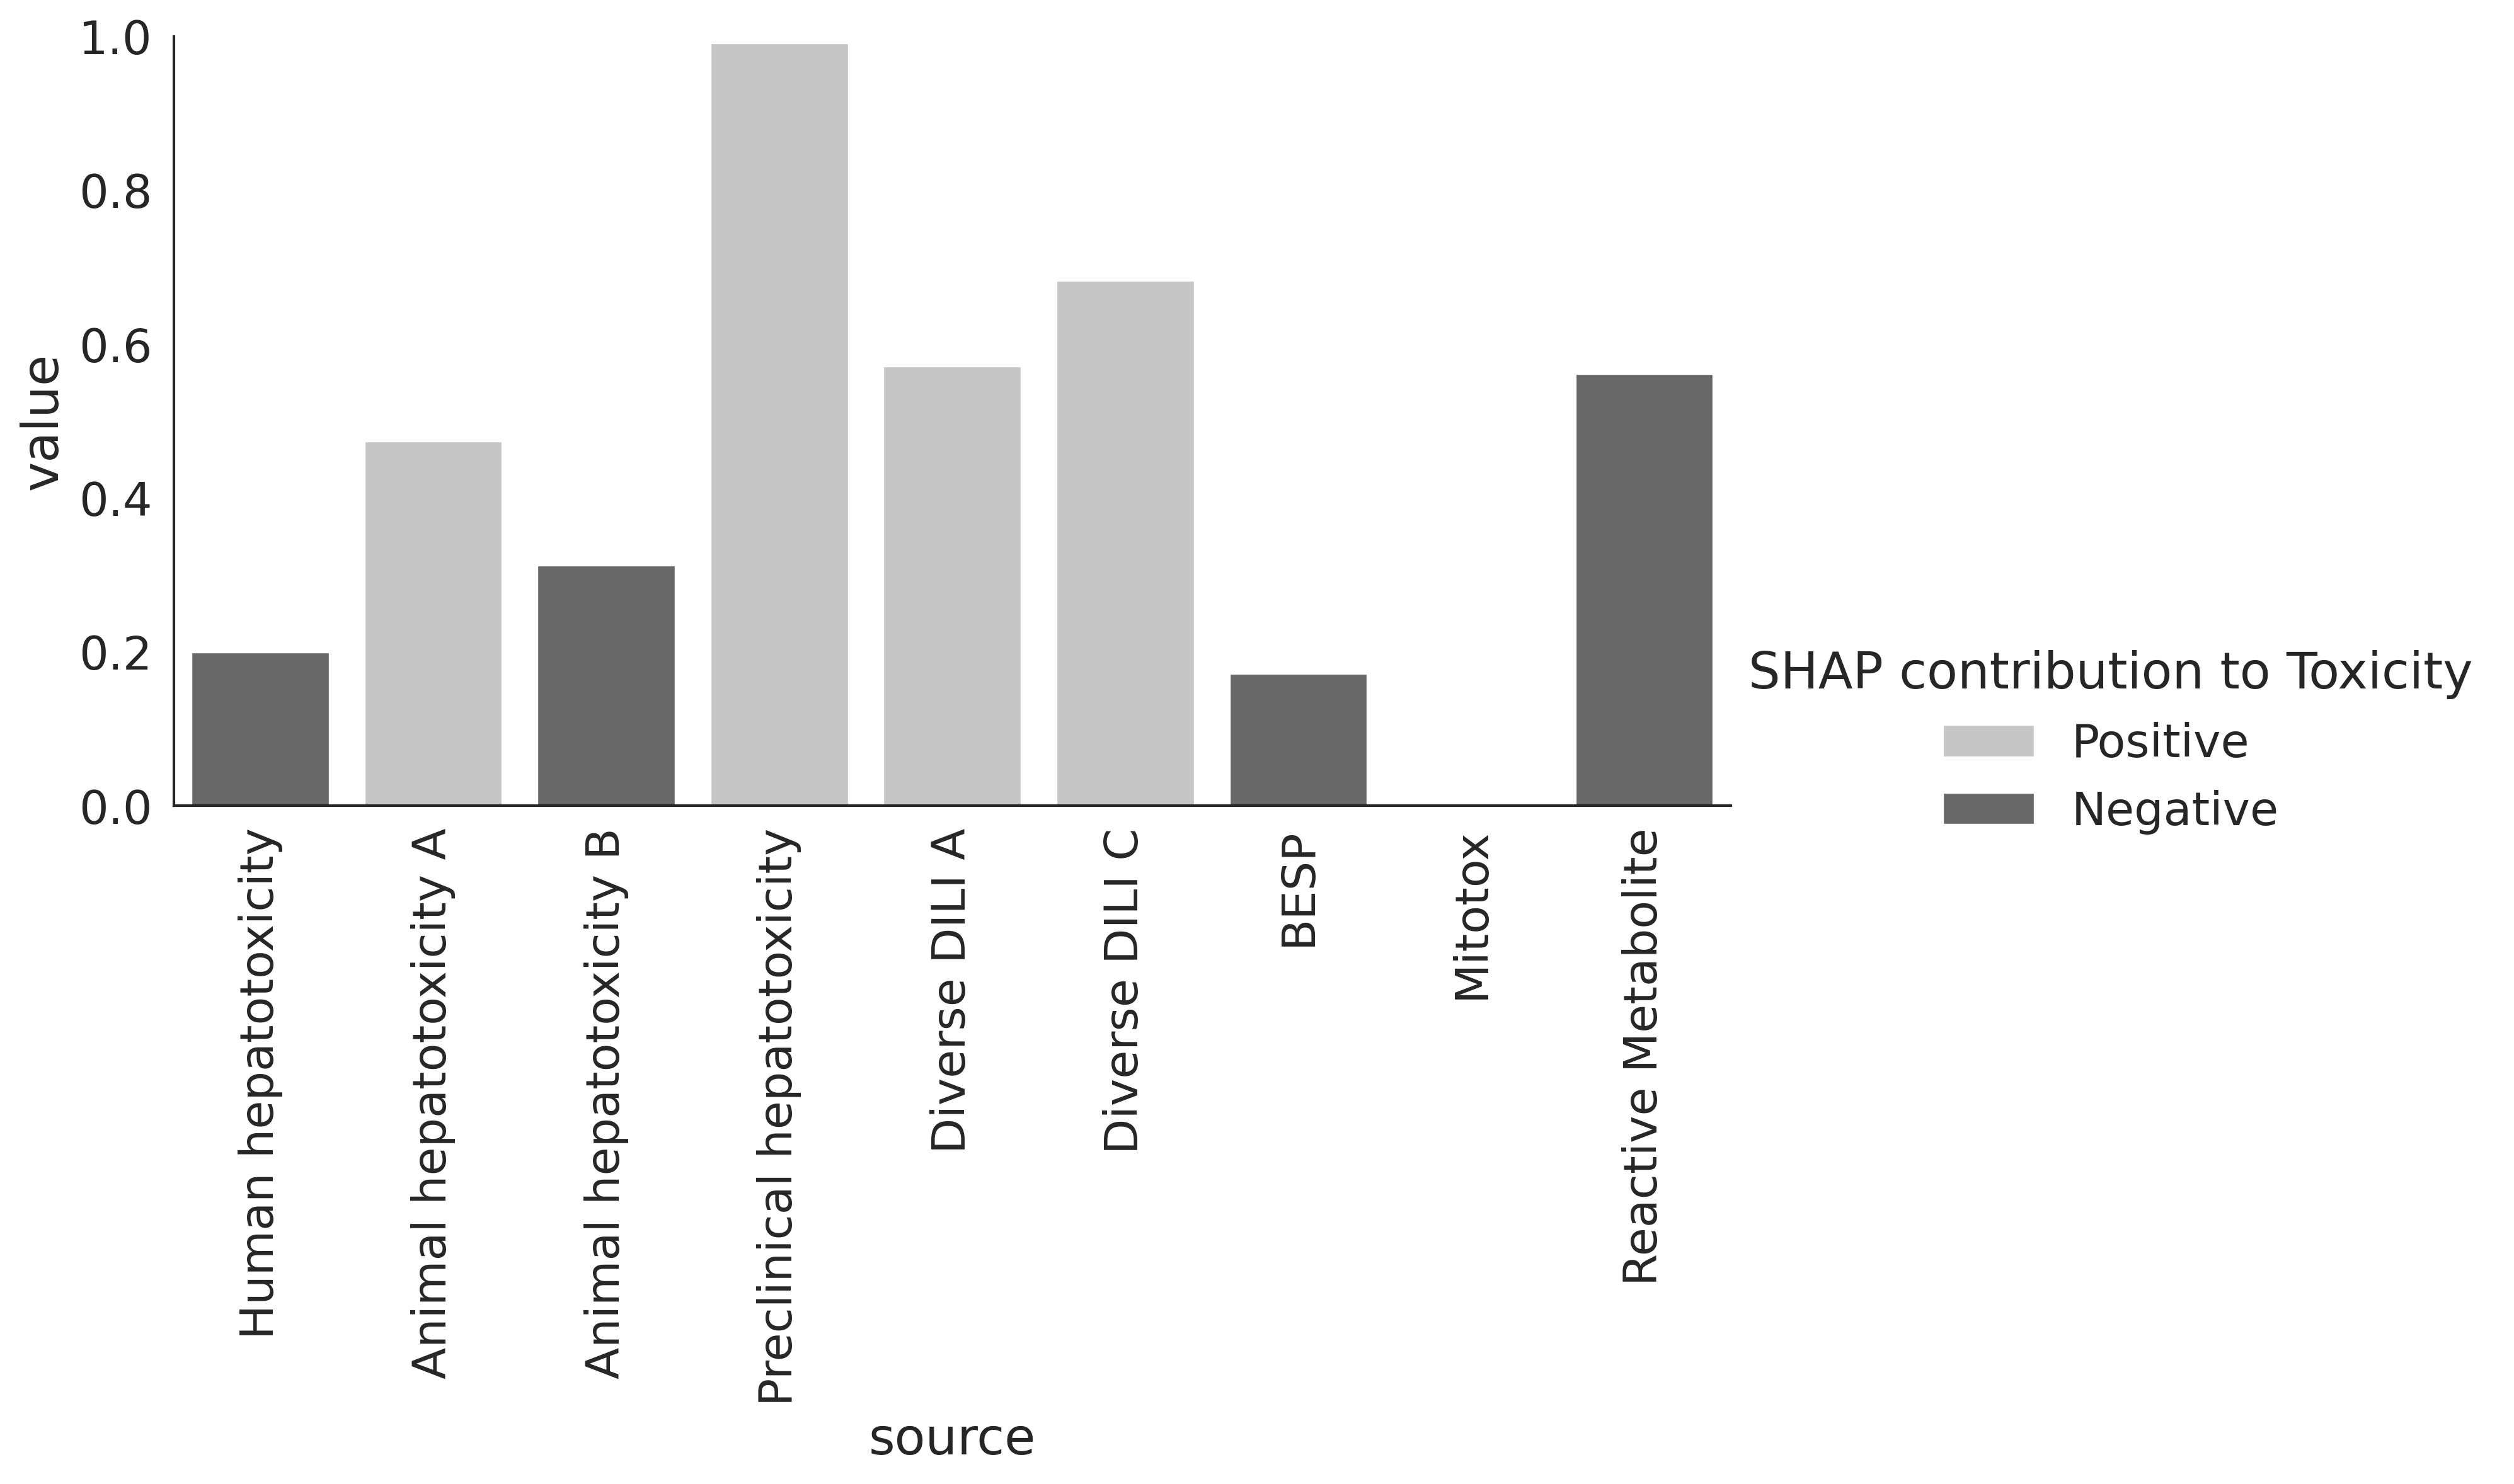

Astaxanthin
9


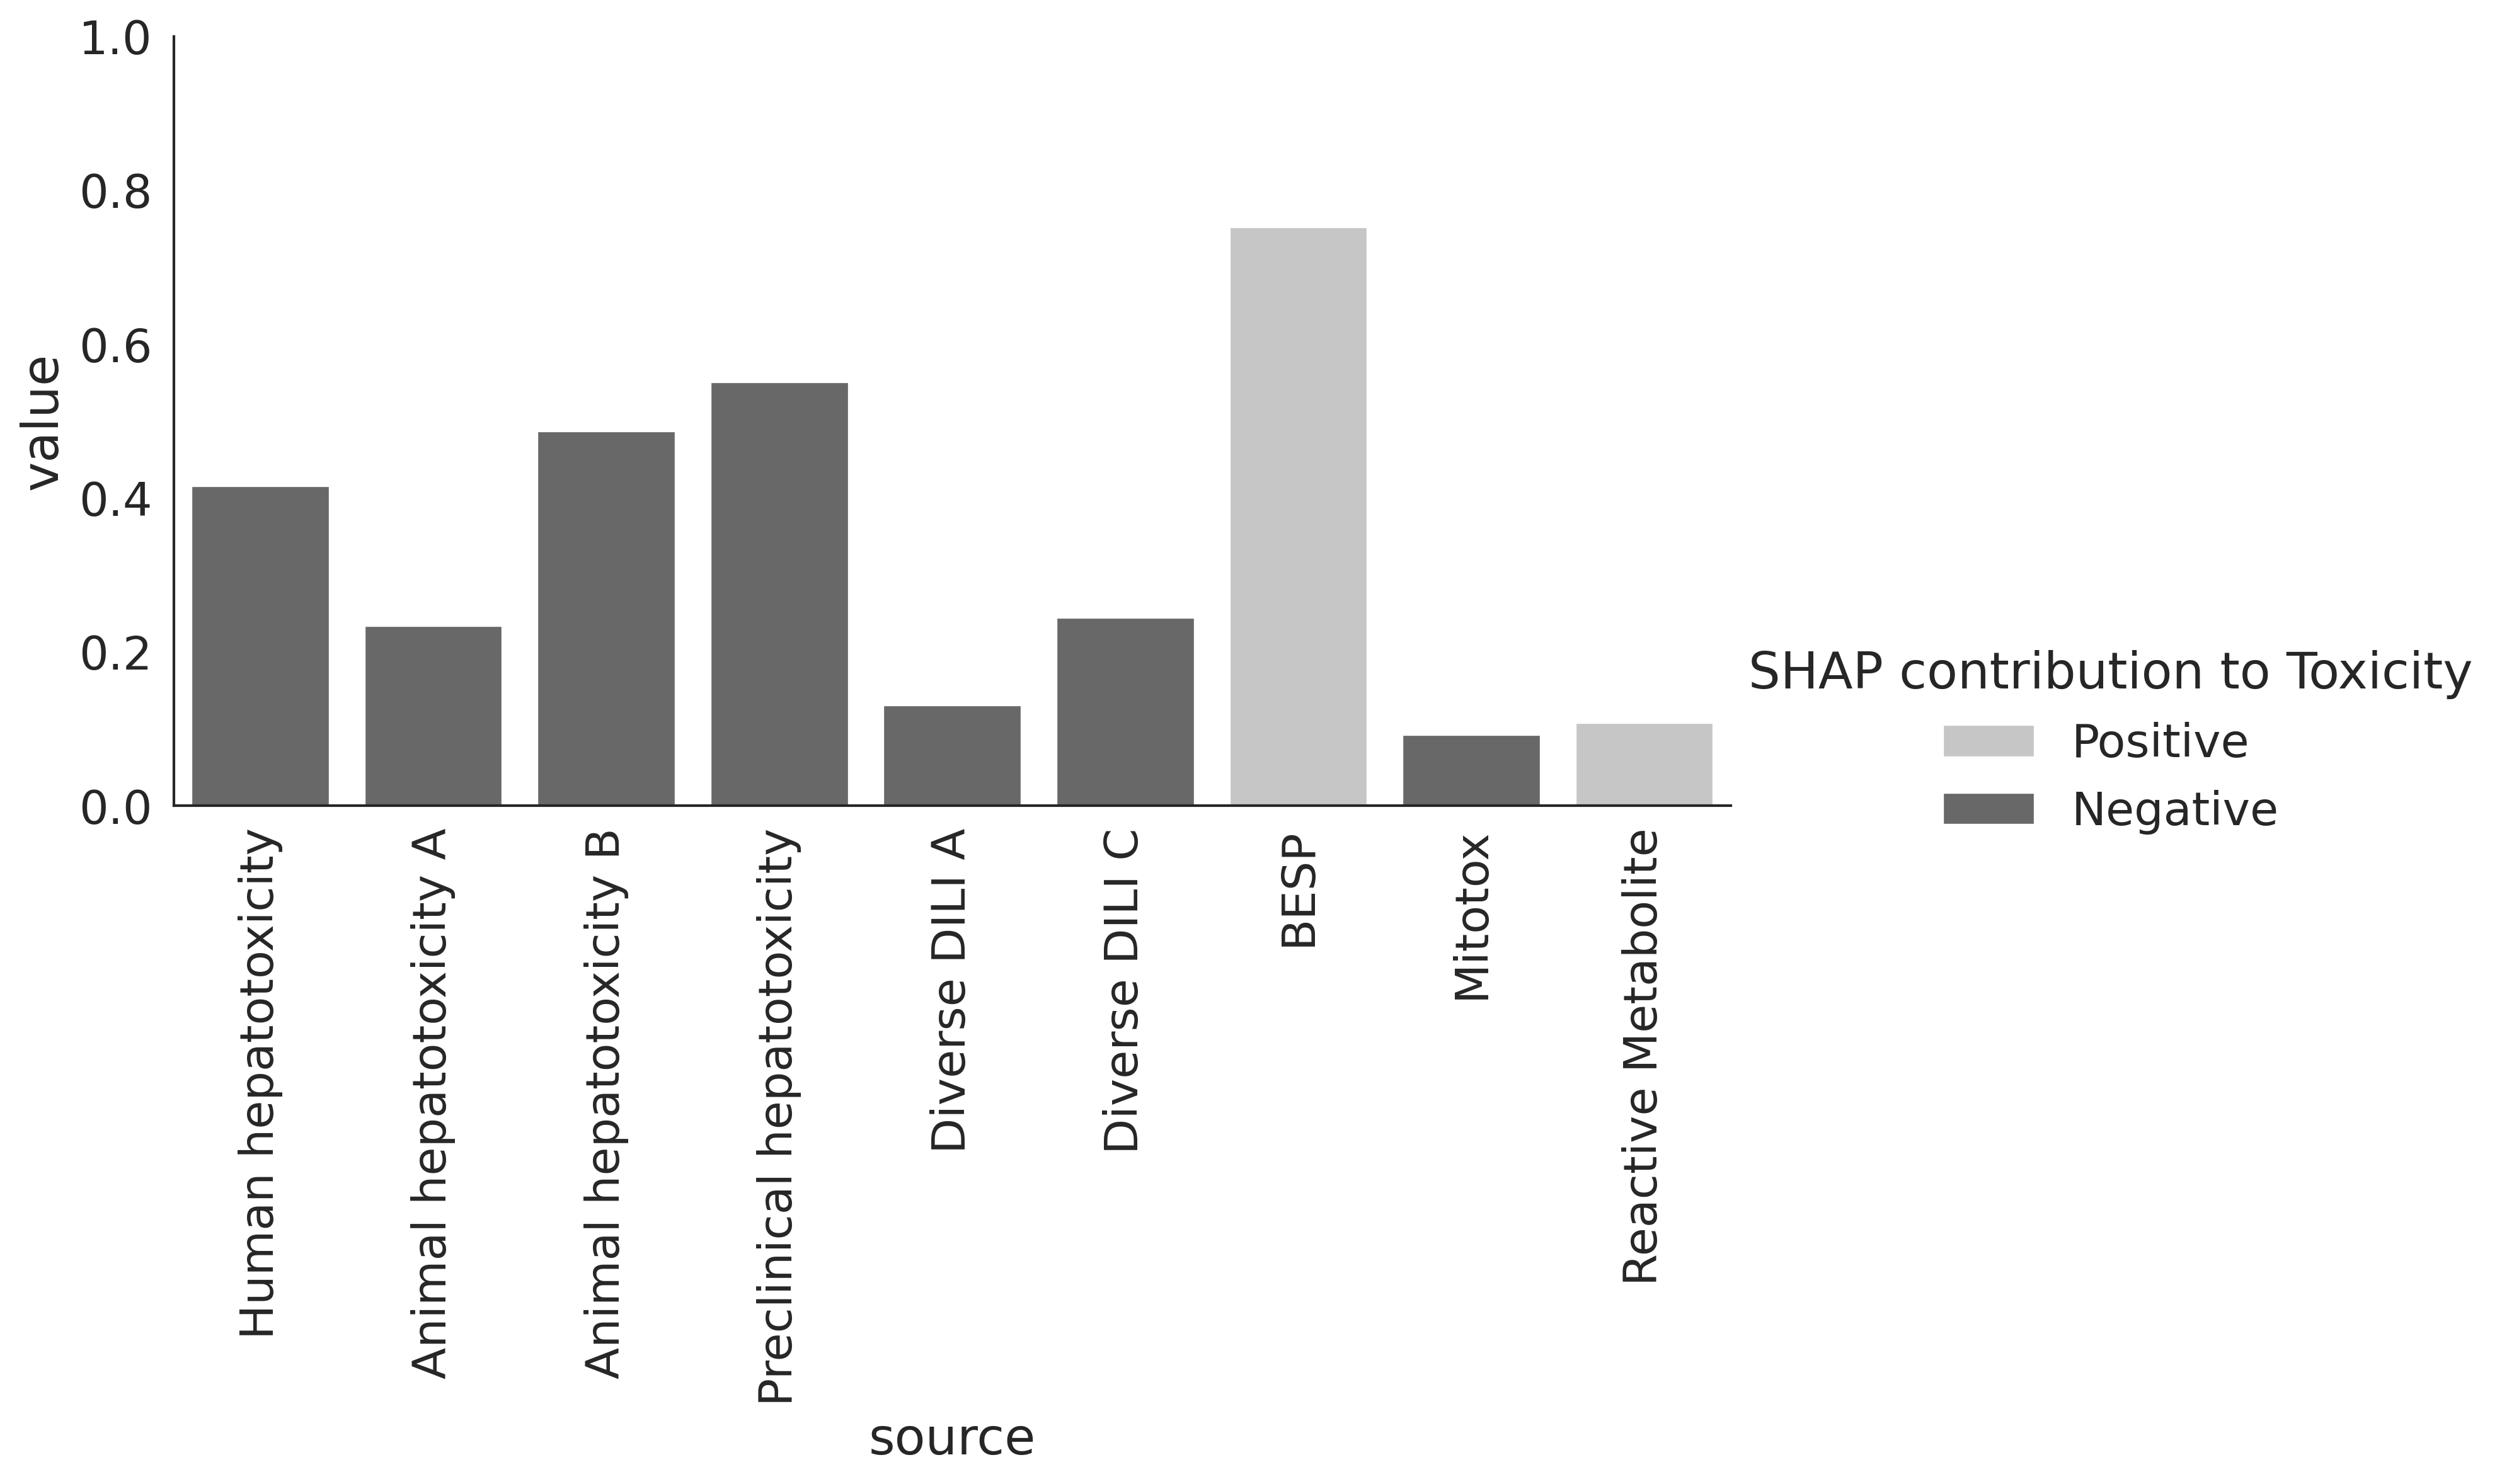

Enzalutamide
9


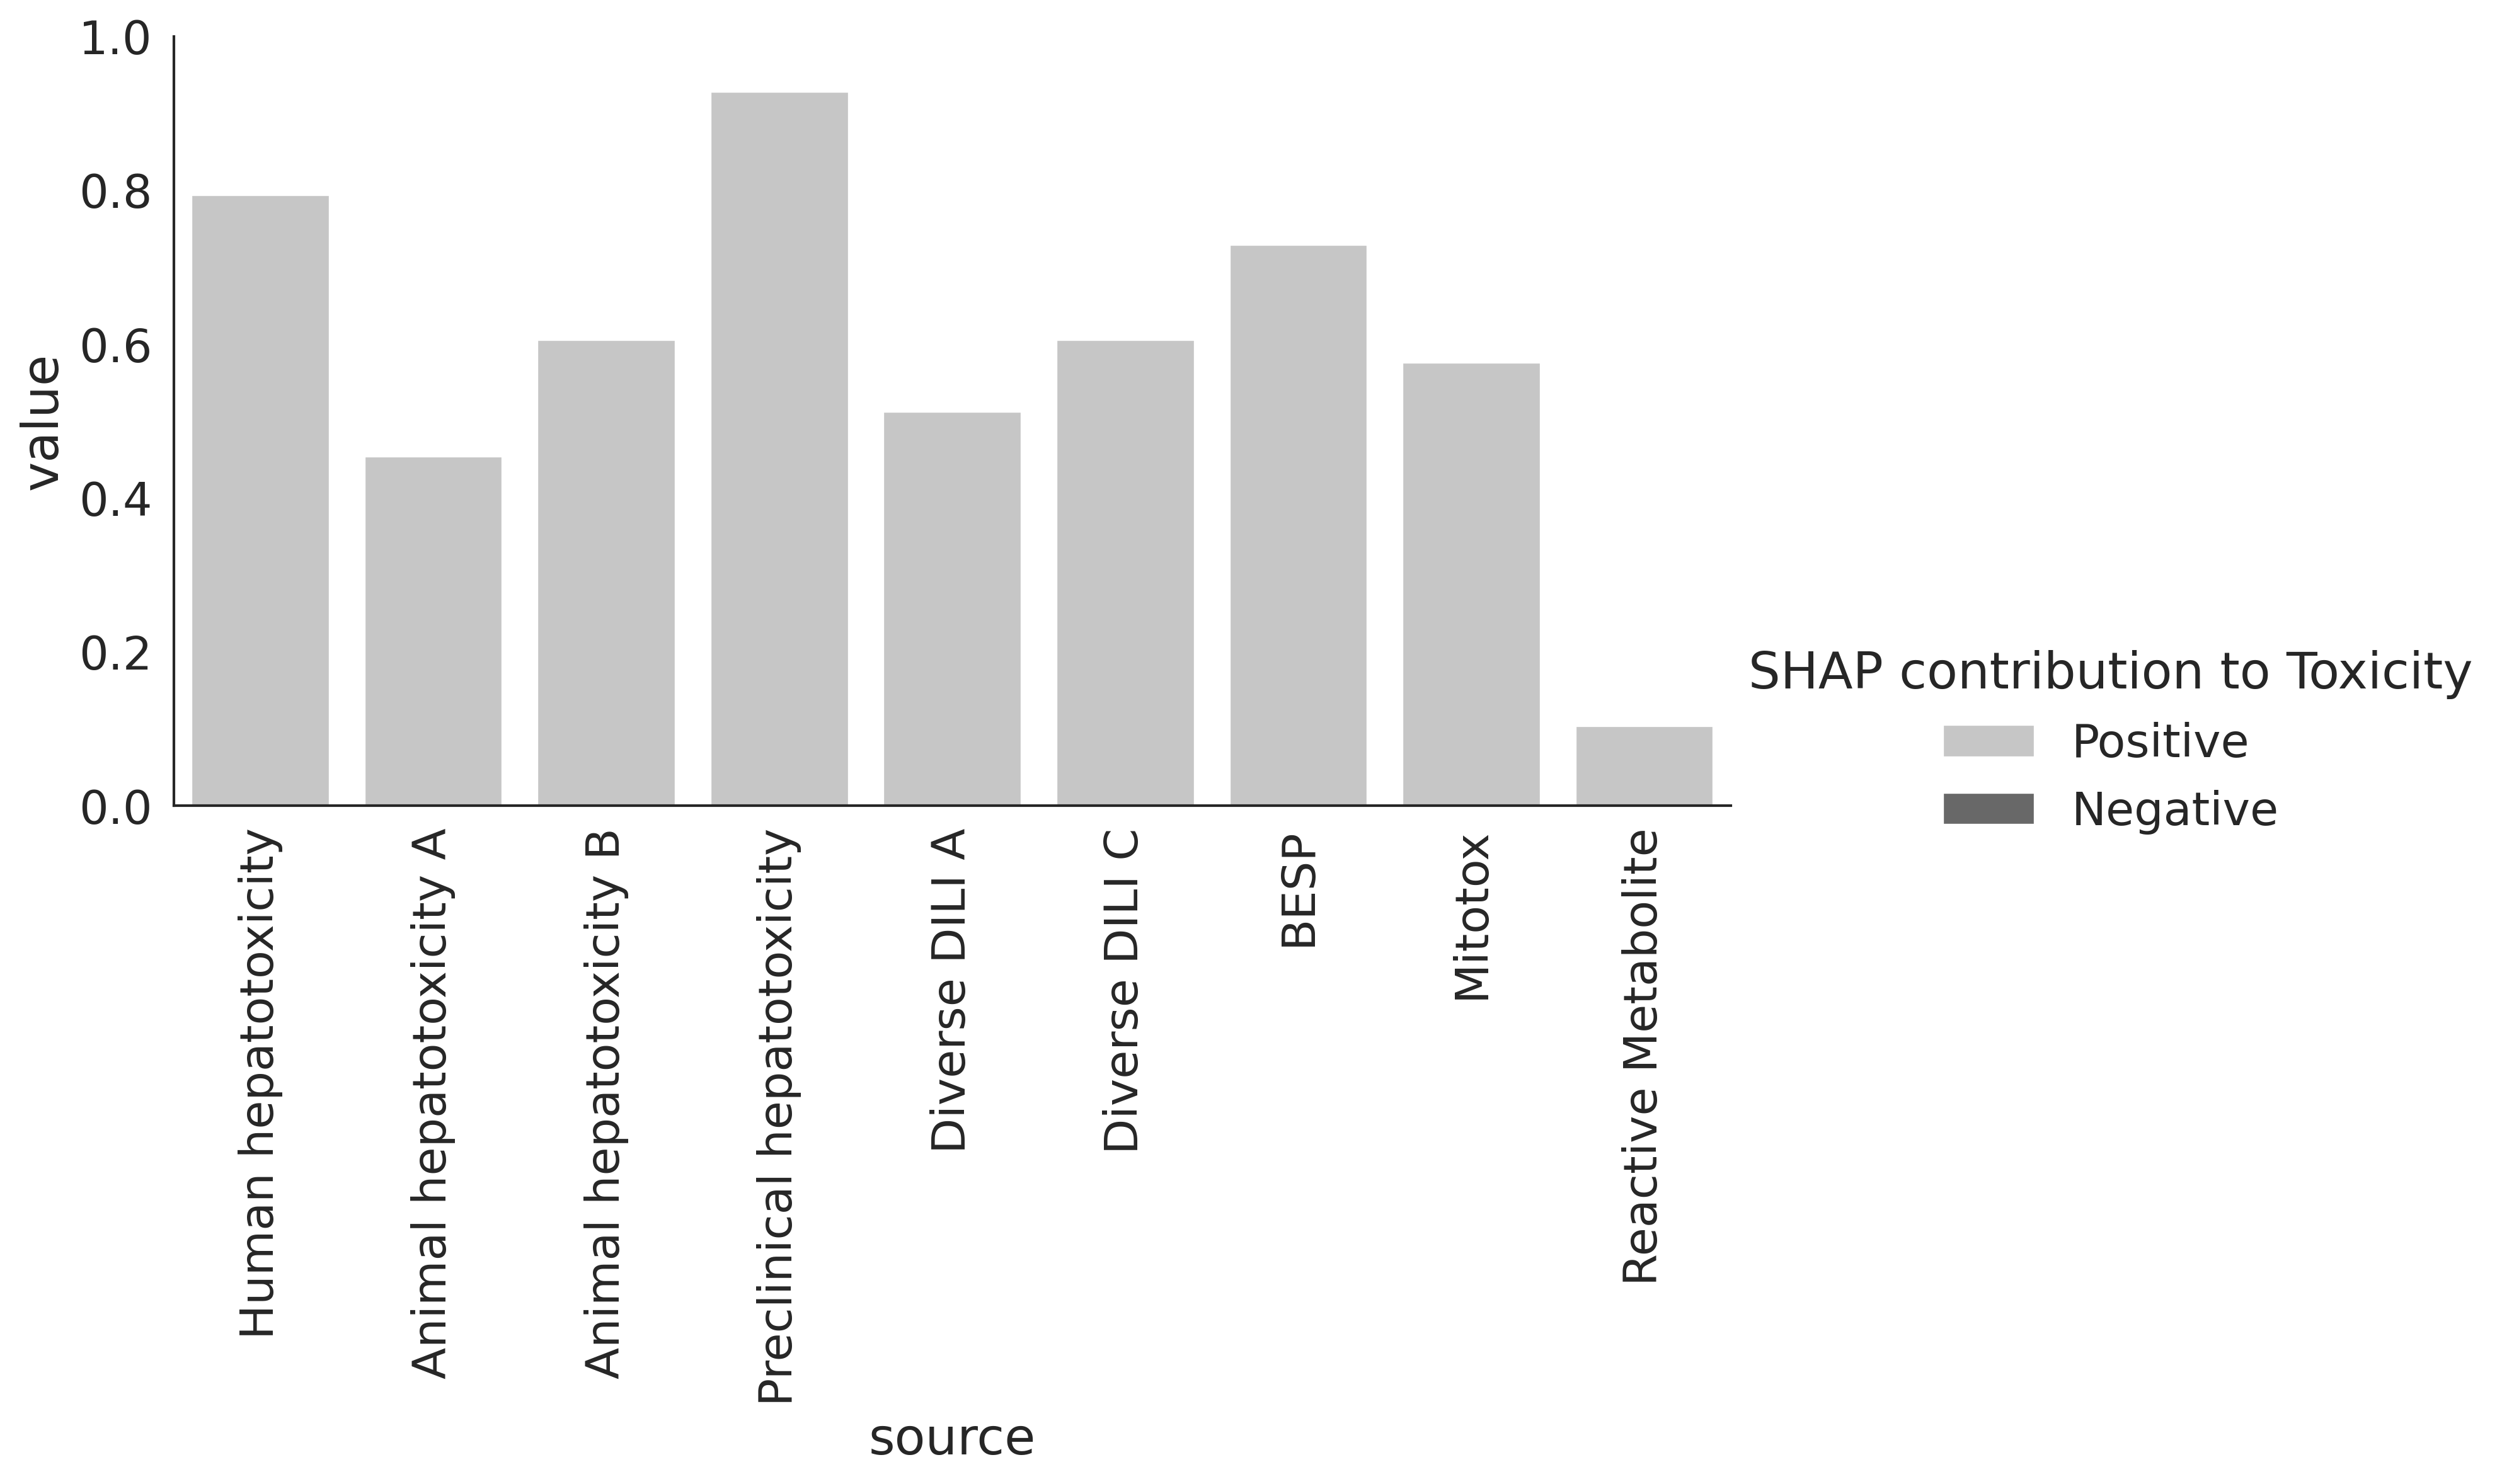

Sitaxentan
9


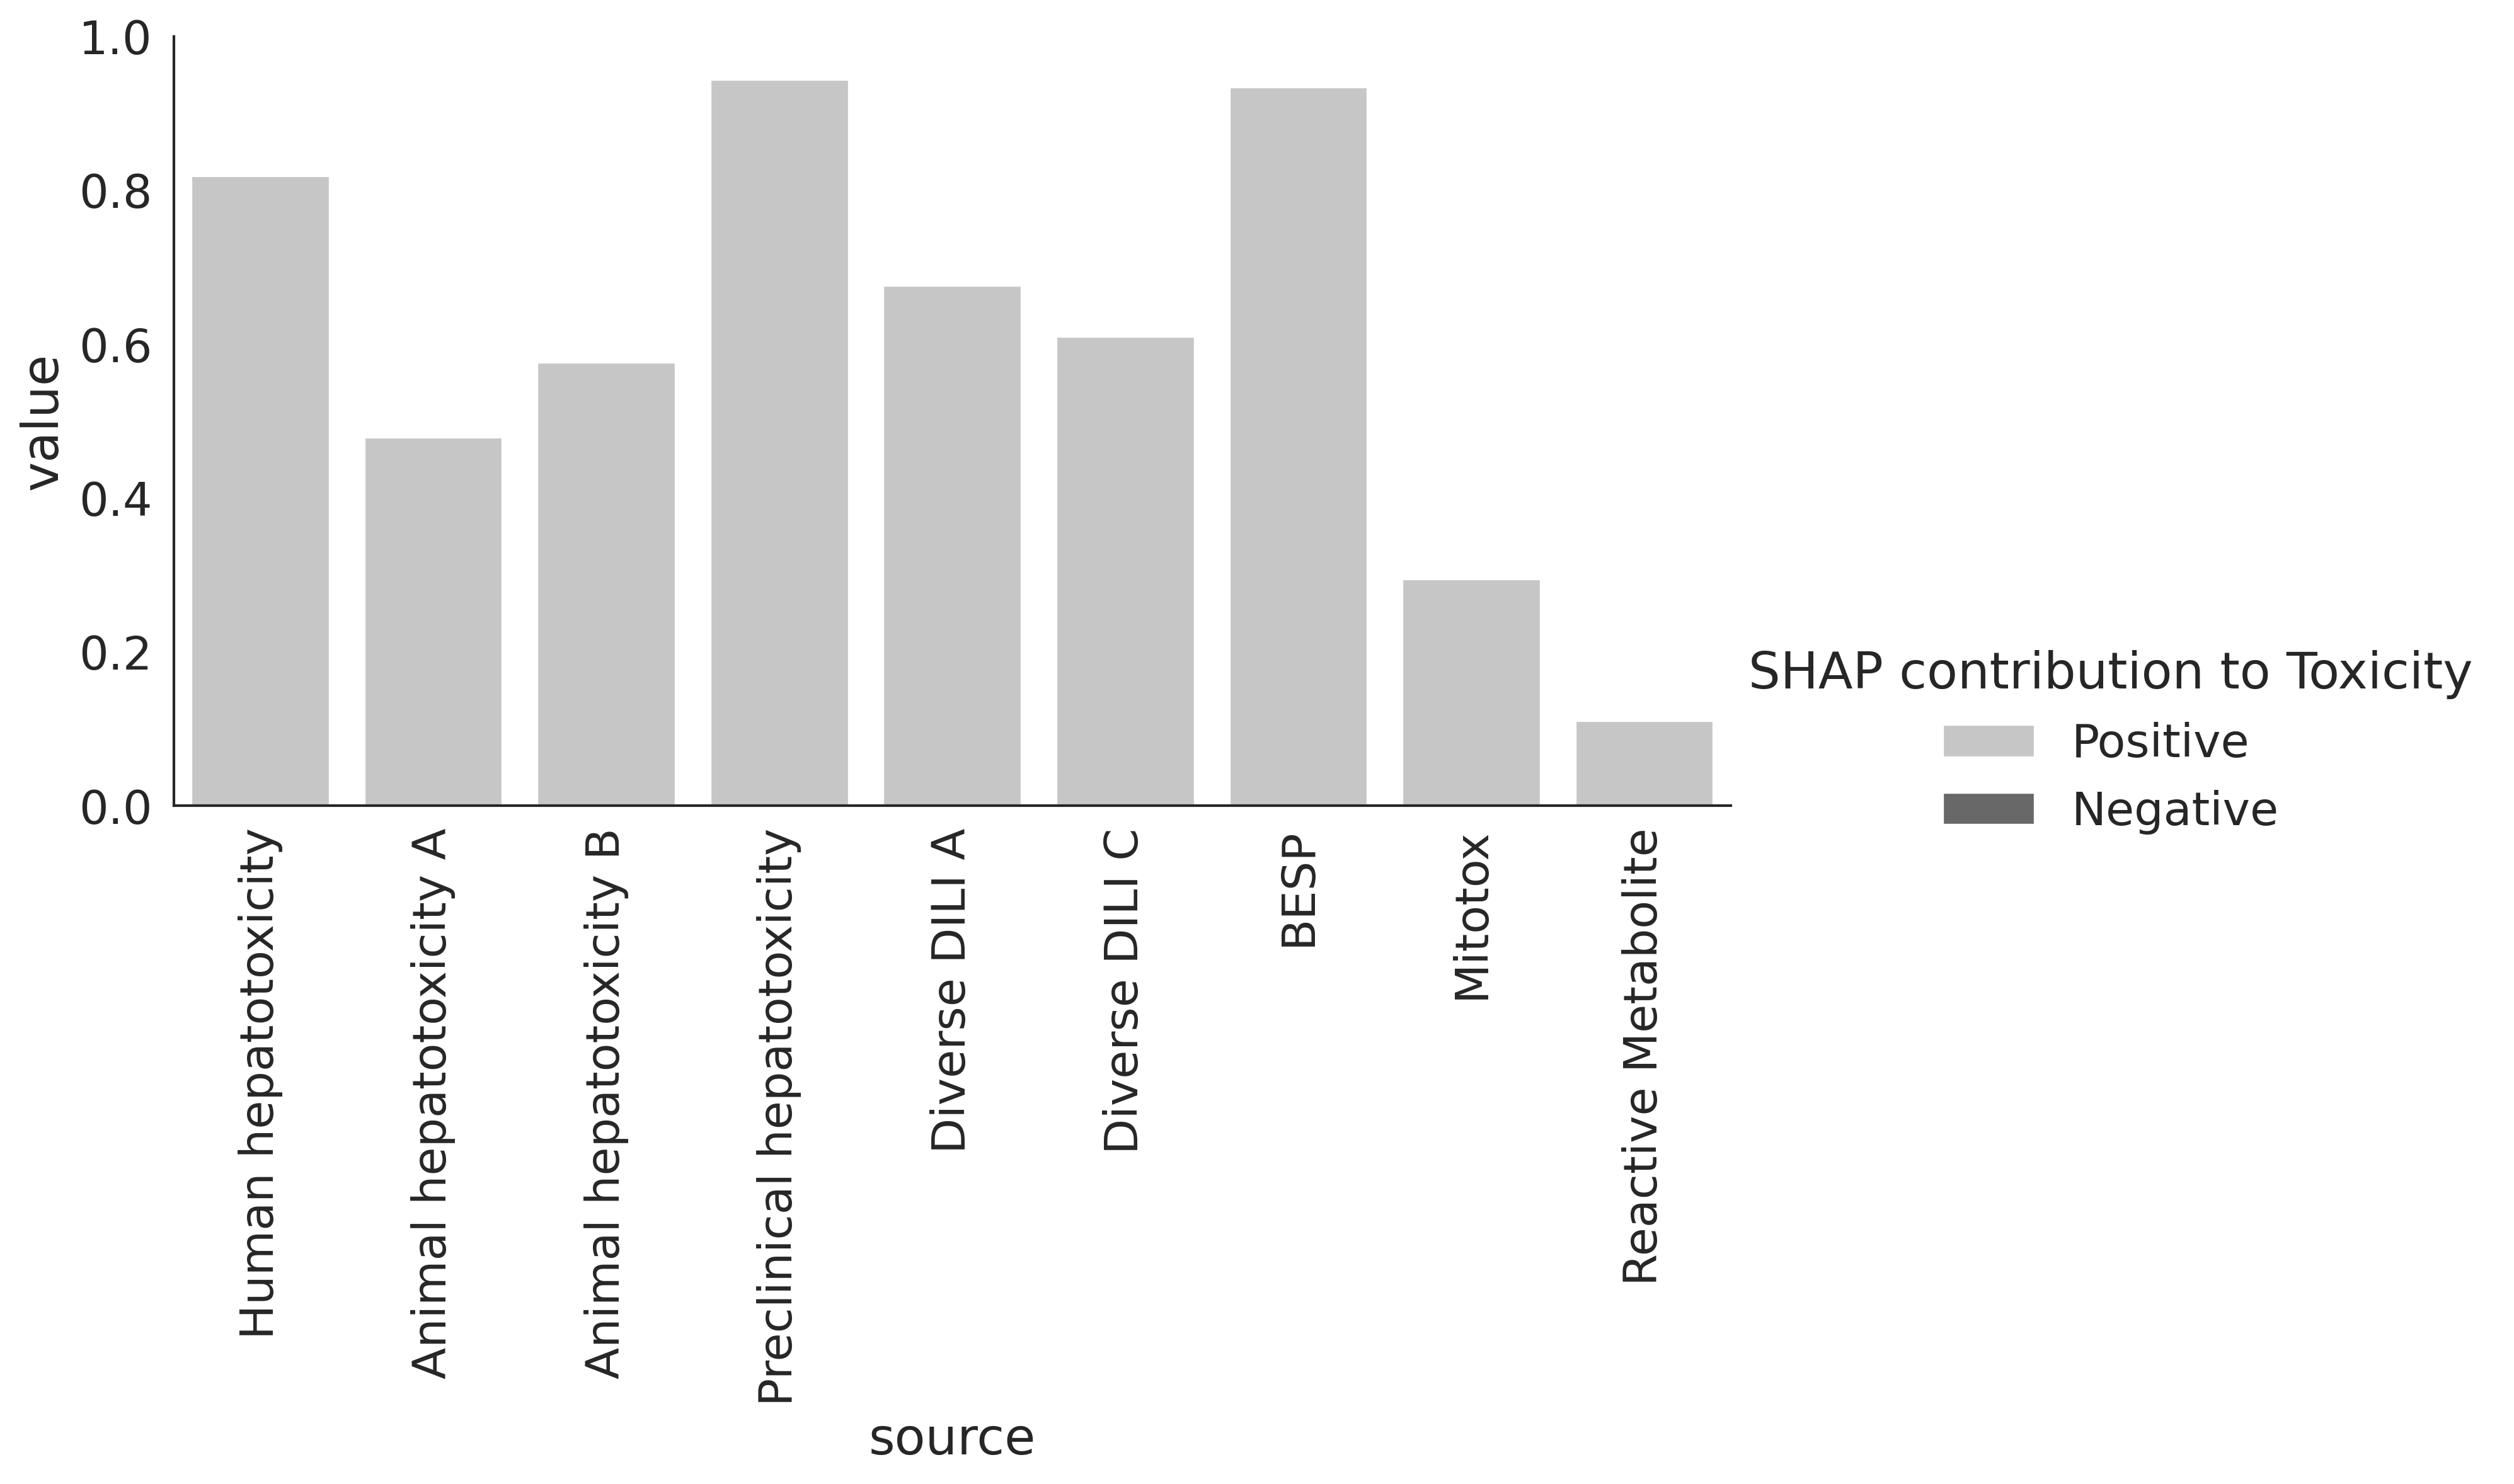

In [33]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

for compound_name in SHAP.compound.unique():
    print(compound_name)
    
    compound = SHAP[SHAP["compound"]==compound_name].sort_values(by=["name"], ascending=True)
    print(len(compound))
    

    #fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    sns.set_style('white')
    sns.set_context('paper', font_scale=2)
    hue_order = ['Positive', 'Negative']
    #sns.barplot(data=compound, x="source", y="value", color='grey')
    g = sns.catplot(data=compound, x="source", y="value", kind="bar",hue_order=hue_order,  hue="SHAP contribution to Toxicity",  
                    palette="Greys", 
                    height=5, aspect=2, dodge=False)
    #plt.axhline(y=0.5, color='r', linestyle='--')
    g.set_xticklabels(rotation=90)
    g.set(ylim=(0, 1))
    plt.show()

In [34]:
compound = SHAP[SHAP["compound"]=="2-Butoxyethanol"].sort_values(by=["name"], ascending=True)
compound.sort_values(by="SHAP", ascending=False)

,name,source,assaytype,SHAP,description,value,pred,influence,smiles,SHAP contribution to Toxicity,compound
1,7,Preclinical hepatotoxicity,Animal hepatotoxicity,0.020985,Preclinical hepatotoxicity data from PharmaPen...,0.991872,True,NaN,CCCCOCCO,Positive,2-Butoxyethanol
2,8,Diverse DILI A,Heterogenous Data,0.005413,Large-scale and diverse ddrug induced liver in...,0.571555,True,NaN,CCCCOCCO,Positive,2-Butoxyethanol
3,11,Diverse DILI C,Heterogenous Data,0.004235,"Transient liver function abnormalities, advers...",0.683299,True,NaN,CCCCOCCO,Positive,2-Butoxyethanol
0,5,Animal hepatotoxicity A,Animal hepatotoxicity,0.002946,"Rat, chronic oral administration, Hepatic hist...",0.474123,False,NaN,CCCCOCCO,Positive,2-Butoxyethanol
2,14,BESP,Mechanisms of Liver Toxicity,-0.000216,BESP Bile Salt Export Pump Inhibition,0.172278,False,NaN,CCCCOCCO,Negative,2-Butoxyethanol
4,16,Reactive Metabolite,Mechanisms of Liver Toxicity,-0.000719,Reactive Metabolite Formation,0.561835,True,NaN,CCCCOCCO,Negative,2-Butoxyethanol
1,6,Animal hepatotoxicity B,Animal hepatotoxicity,-0.001956,"Hepatocellular hypertrophy, rats, ORAD, HESS",0.313287,False,NaN,CCCCOCCO,Negative,2-Butoxyethanol
0,3,Human hepatotoxicity,Human hepatotoxicity,-0.006702,"Human hepatotoxicity, hepatobiallry",0.199695,False,NaN,CCCCOCCO,Negative,2-Butoxyethanol
3,15,Mitotox,Mechanisms of Liver Toxicity,-0.008084,Mitotox,0.00126,False,NaN,CCCCOCCO,Negative,2-Butoxyethanol


In [35]:
for name in SHAP["compound"].unique():
    print(name)
    compound = SHAP[SHAP["compound"]==name].sort_values(by=["name"], ascending=True)
    pos= compound[compound["SHAP"]>0].sort_values(by="SHAP", ascending=False)
    neg = compound[compound["SHAP"]<0].sort_values(by="SHAP", ascending=True)
    
    #print(compound)
    
    if (name=="2-Butoxyethanol"):
    
        print(neg.source.to_list()[:3])
        
    elif (name=="Astaxanthin"):  
        
        print(neg.source.to_list()[:3])
        
    else:
        
        print(pos.source.to_list()[:3])

2-Butoxyethanol
['Mitotox', 'Human hepatotoxicity', 'Animal hepatotoxicity B']
Astaxanthin
['Diverse DILI A', 'Preclinical hepatotoxicity', 'Diverse DILI C']
Enzalutamide
['Preclinical hepatotoxicity', 'Human hepatotoxicity', 'Mitotox']
Sitaxentan
['Preclinical hepatotoxicity', 'Human hepatotoxicity', 'Mitotox']


In [36]:
compound.source.to_list()[-3:]

['BESP', 'Mitotox', 'Reactive Metabolite']

In [37]:
maccsshap = pd.DataFrame(list_of_lists, columns=["SMILES", "name", "topMACCS", "bottomMACCS"])
maccsshap

,SMILES,name,topMACCS,bottomMACCS
0,CCCCOCCO,2-Butoxyethanol,[CH3]~[CH2]~*,*~[CH2]~[!#6;!#1;!H0]
1,CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=...,Astaxanthin,*!@*@*!@*,*~*(~*)(~*)~*
2,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,Enzalutamide,*!@*@*!@*,[!#6;!#1]~*(~[!#6;!#1])~[!#6;!#1]
3,Cc1cc2c(cc1CC(=O)c1sccc1S(=O)(=O)N=c1o[nH]c(C)...,Sitaxentan,*@*!@[#7],[!#6;!#1]~[CH2]~*


2-Butoxyethanol
[CH3]~[CH2]~*


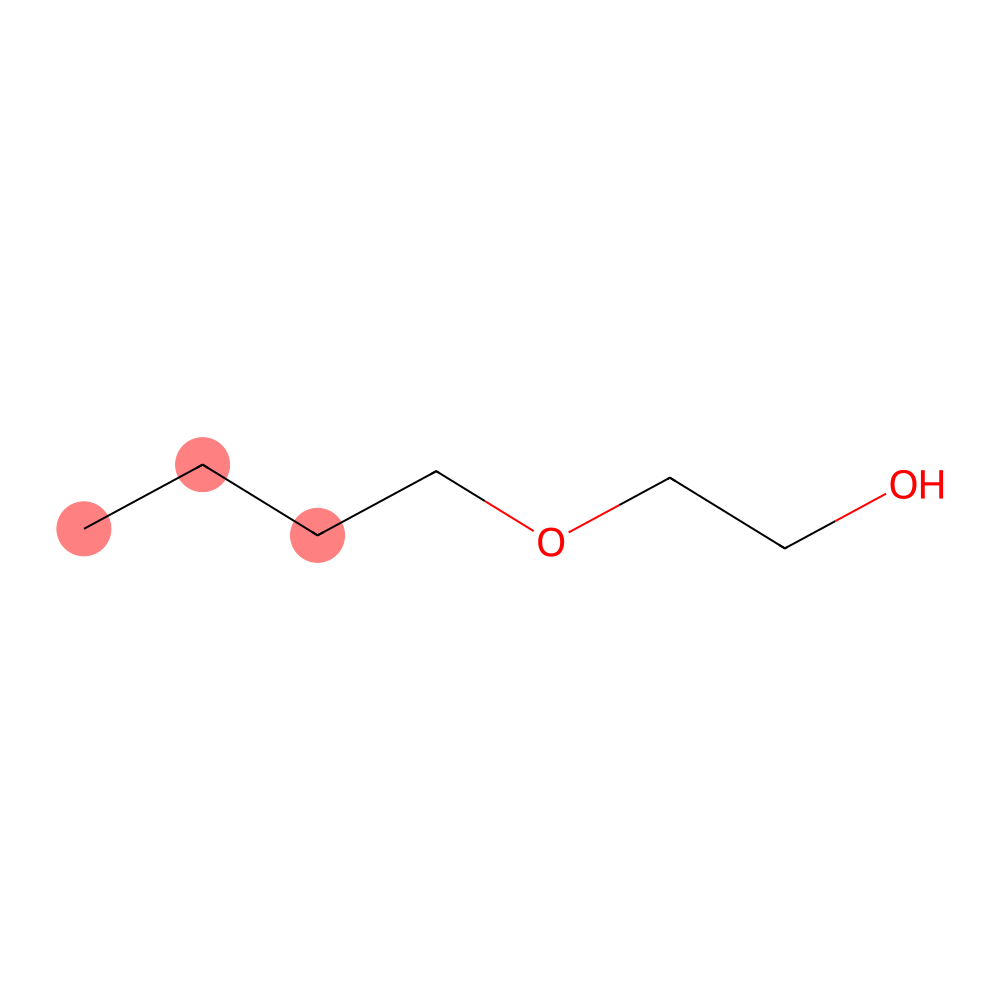

Astaxanthin
*!@*@*!@*


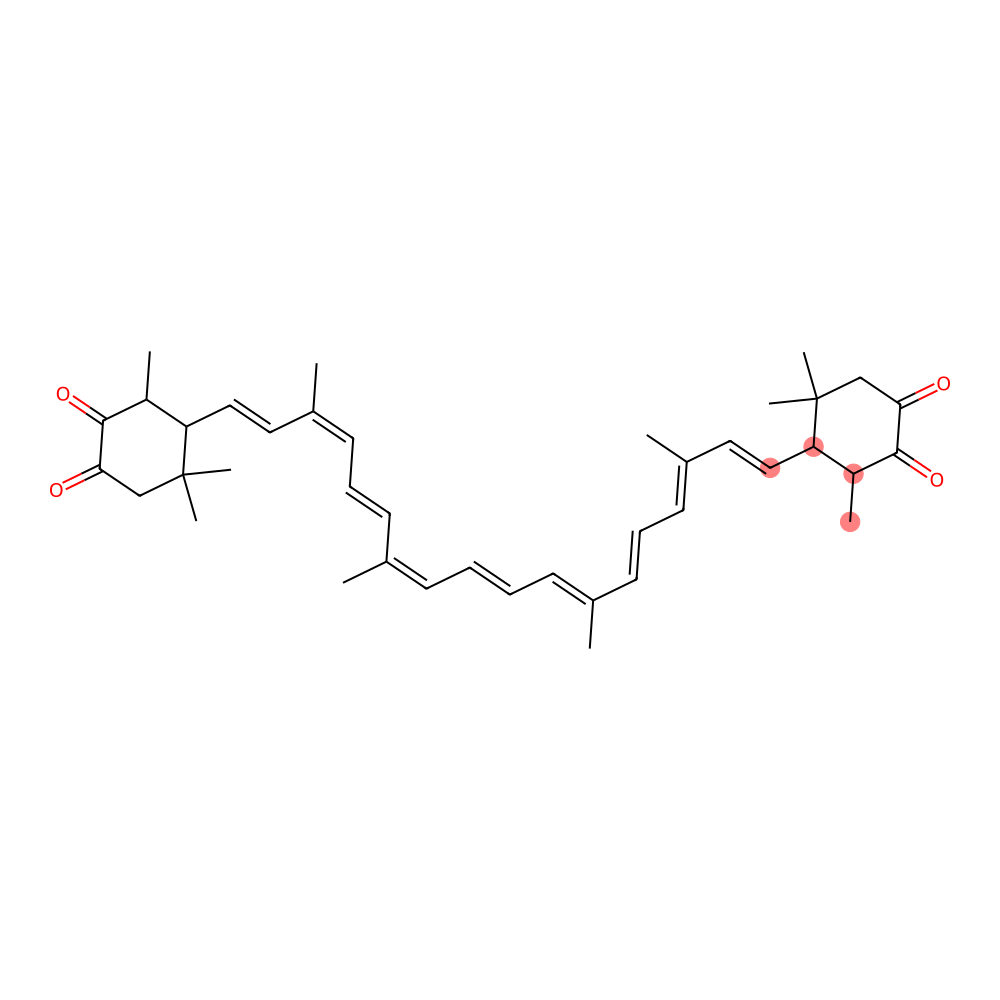

Enzalutamide
*!@*@*!@*


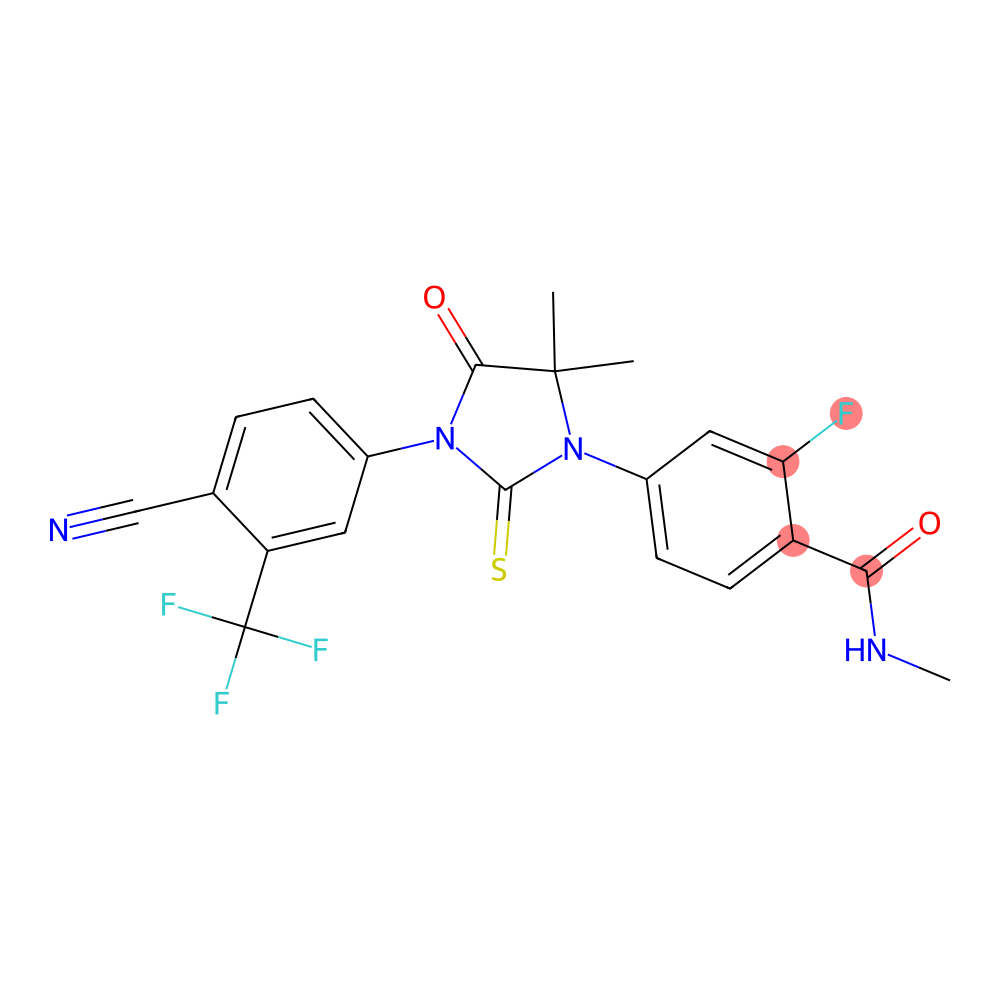

Sitaxentan
*@*!@[#7]


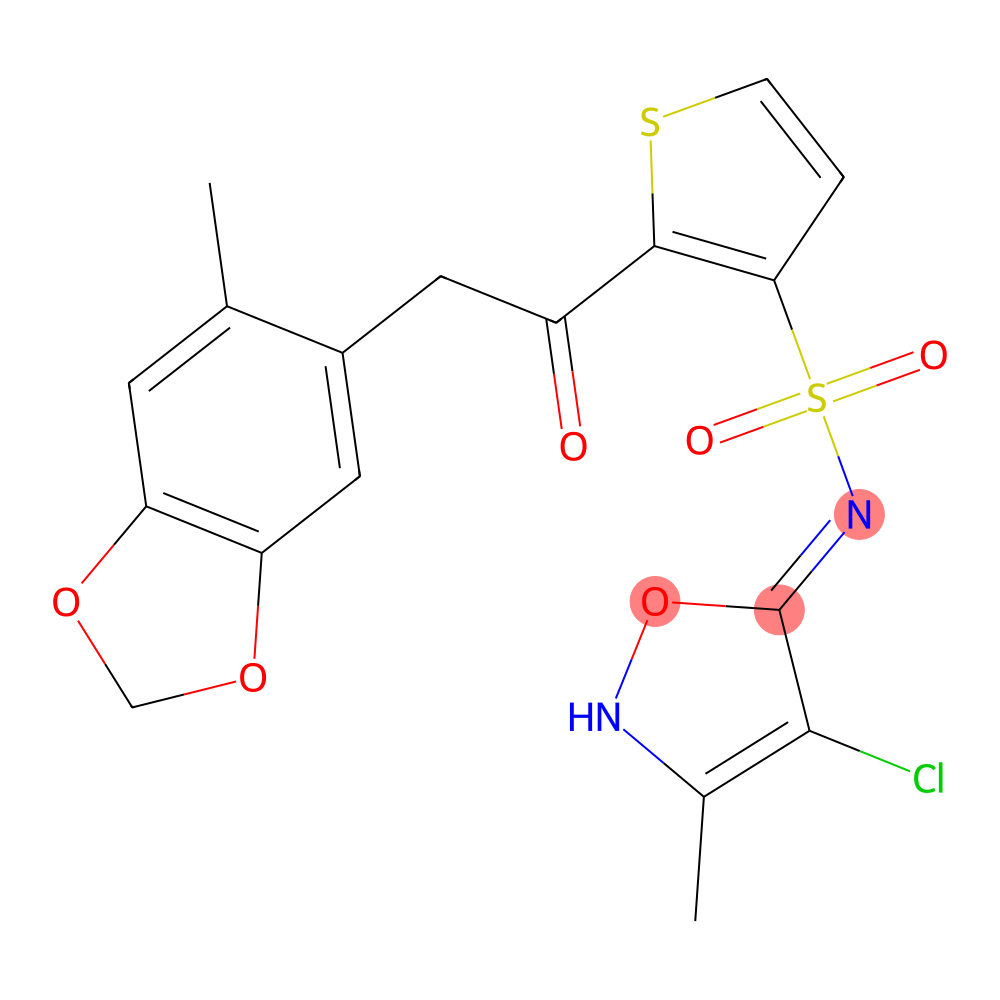

In [38]:
from IPython.display import display, Image
import os

# Assuming the rest of your setup code is already in place

for index, row in maccsshap.iterrows():
    name = row["name"]
    print(name)
    smiles = row["SMILES"]
    top_MACCS = row["topMACCS"]
    print(top_MACCS)
    
    m = Chem.MolFromSmiles(smiles)
    data = Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(Chem.MolFromSmarts(top_MACCS)), size=(1000, 1000),
                          returnPNG=True)

    # Save the image
    image_path = f"./SHAP_molecules/{name}.png"
    data.save(image_path)
    
    # Display the image in the notebook
    if os.path.exists(image_path):
        display(Image(filename=image_path))


In [39]:
top_MACCS

'*@*!@[#7]'

2-Butoxyethanol
*~[CH2]~[!#6;!#1;!H0]


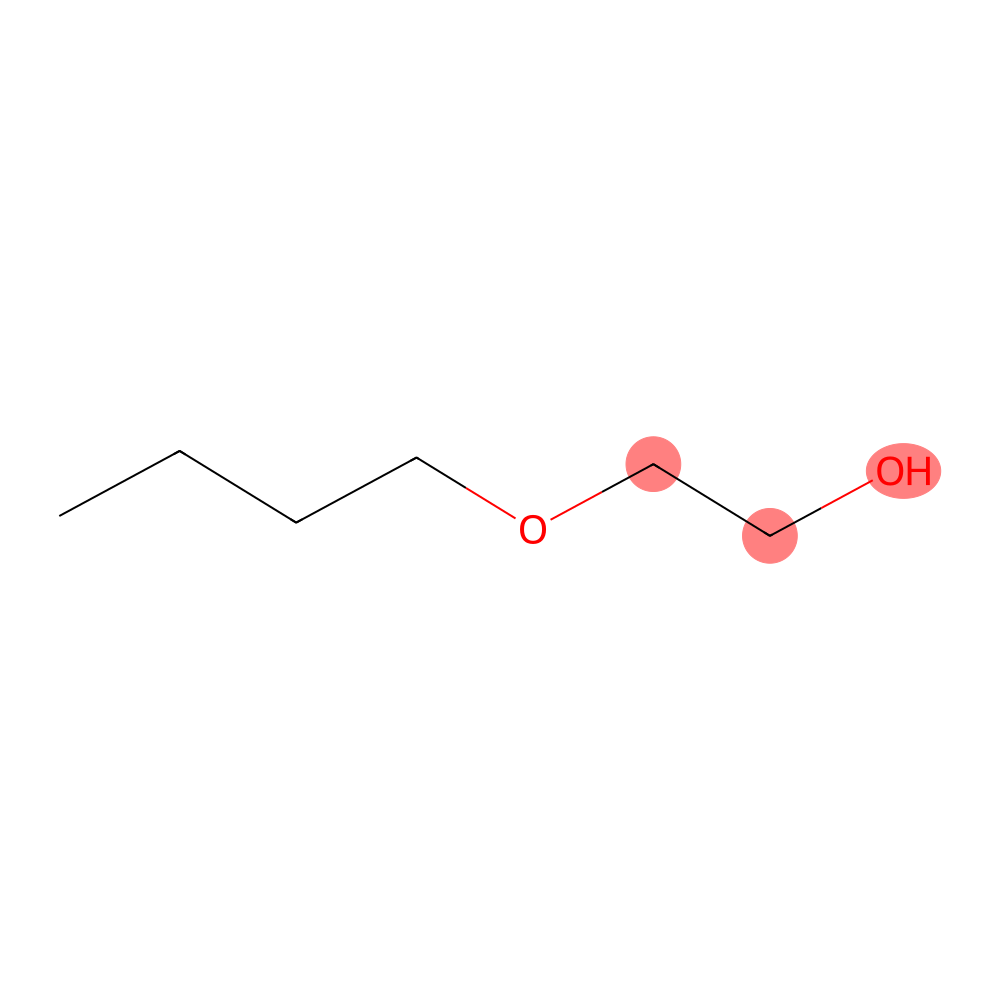

Astaxanthin
*~*(~*)(~*)~*


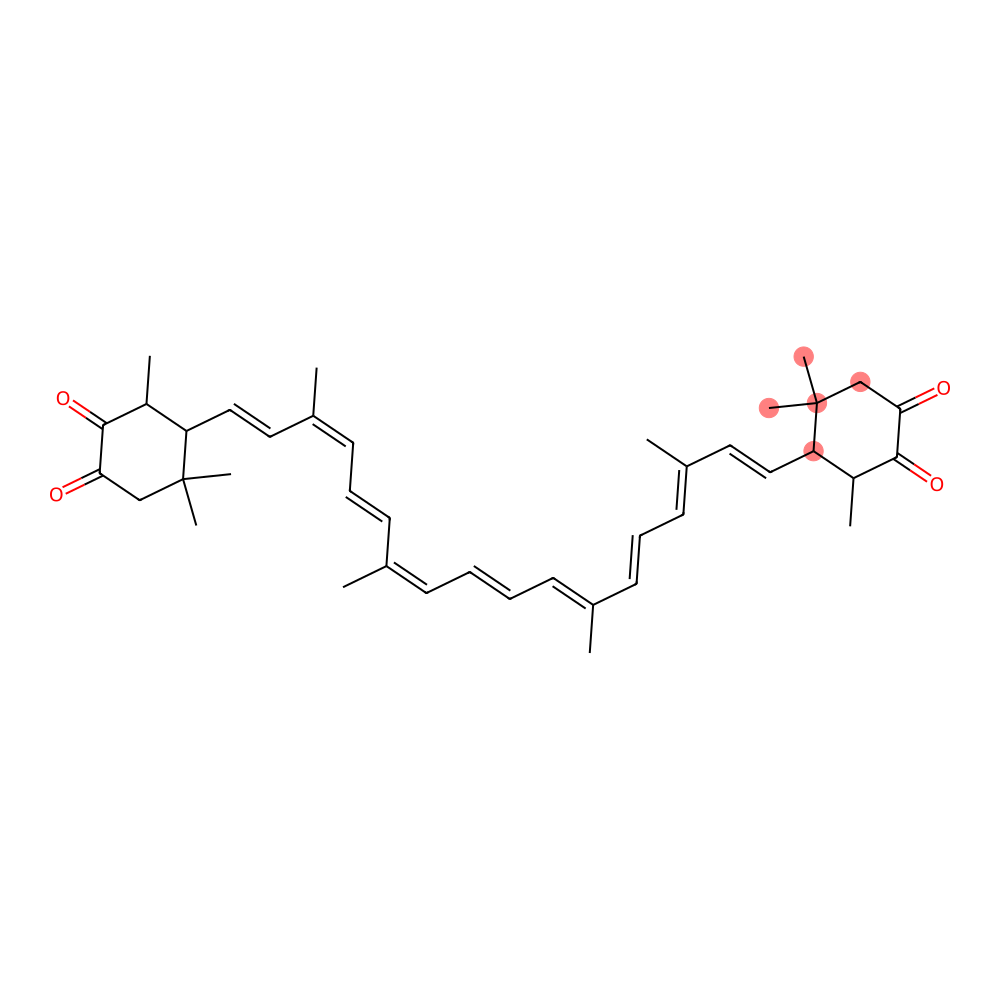

In [40]:
maccsshap_negatives= maccsshap[maccsshap.name.isin(["2-Butoxyethanol","Astaxanthin"])].reset_index(drop=True)

for index, row  in maccsshap_negatives.iterrows():
    #print(row["SMILES"])

    name = row["name"]
    print(name)
    smiles = row["SMILES"]
    top_MACCS = row["bottomMACCS"]
    print(top_MACCS)

    m = Chem.MolFromSmiles(smiles)
    data = Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(Chem.MolFromSmarts(top_MACCS)), size=(1000, 1000),
                              returnPNG=True)
    image_path = f"./SHAP_molecules/{name}.png"
    data.save(image_path)
    
    # Display the image in the notebook
    if os.path.exists(image_path):
        display(Image(filename=image_path))

In [41]:
bottom_MACCS

'[!#6;!#1]~[CH2]~*'

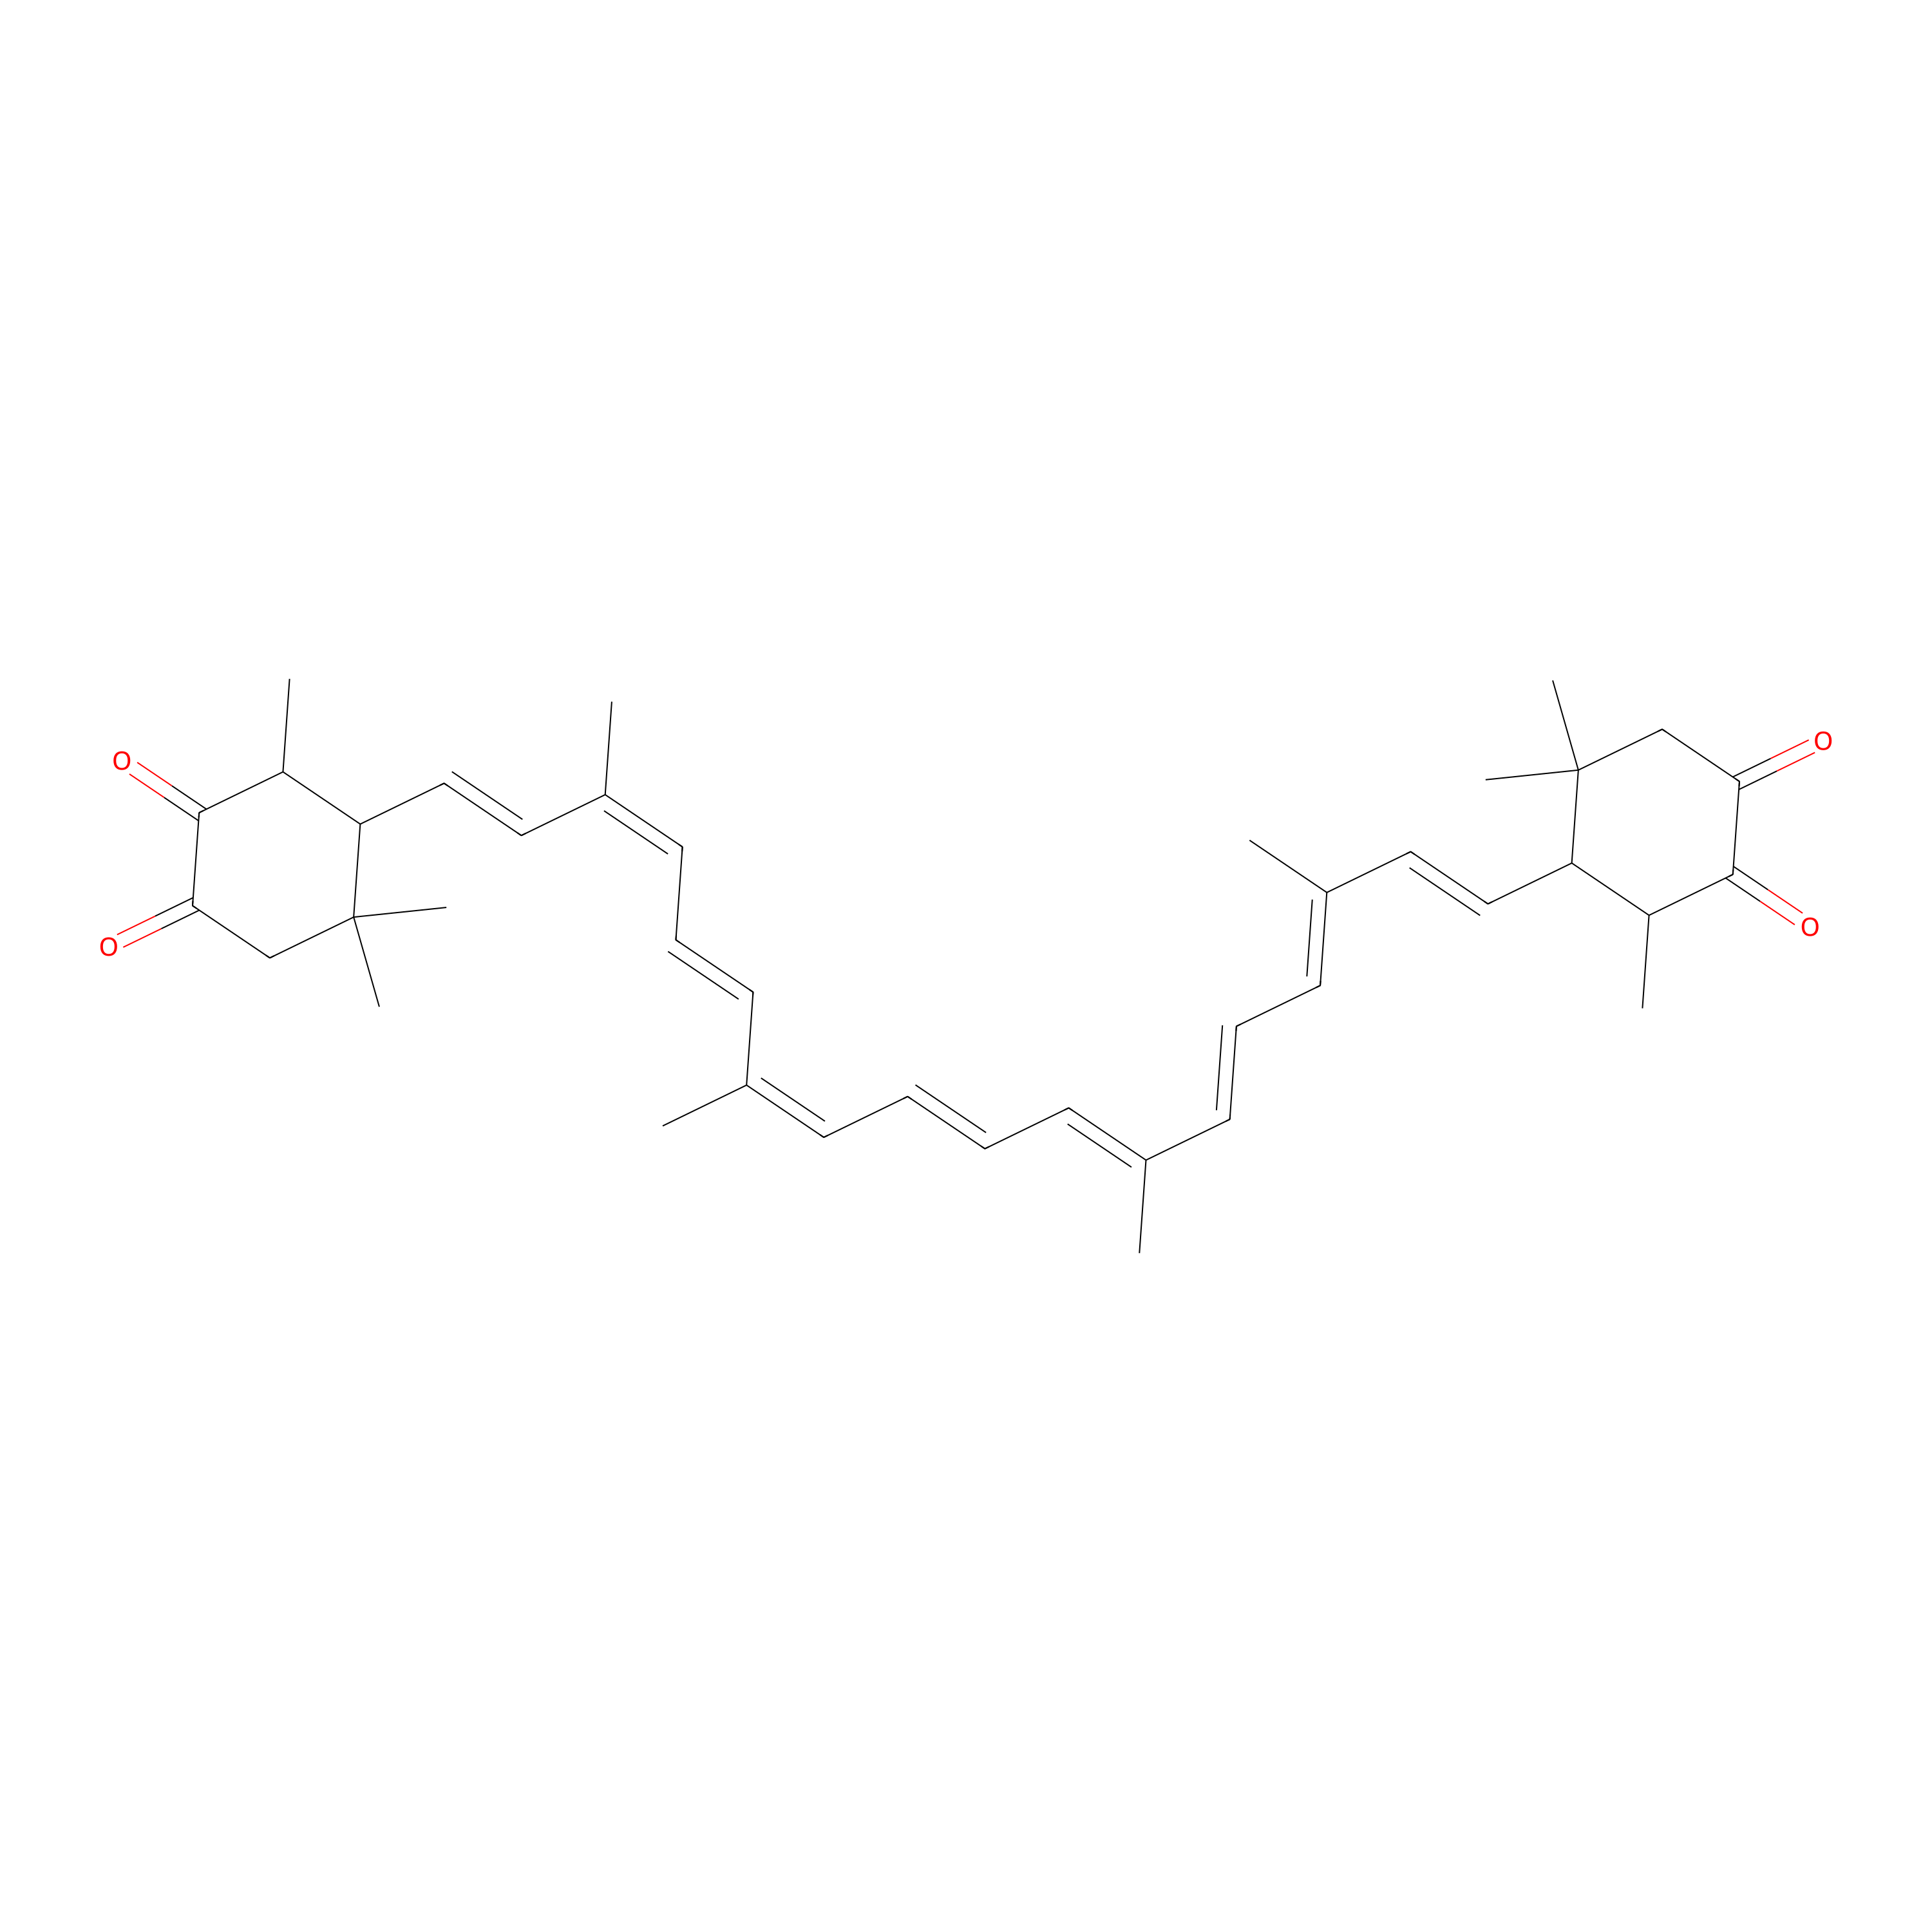

In [42]:
Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(Chem.MolFromSmarts(bottom_MACCS)), size=(3000, 3000))  

In [43]:
#Most important MACCS feature
top[top.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]

,name,SHAP,description,value
776,MACCS100,0.00141,*~[CH2]~[#7],0


In [44]:
m_list=[]
target_list=[]

if (top[top.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0] == 1): 
    
    k = top[top.name.isin(desc.name.to_list()[-166:])]["description"].values[0]
    m = Chem.MolFromSmiles(smiles)
    
    m_list.append(m)
    target_list.append(m.GetSubstructMatches(substructure))

else:
    
    print("Absence of Substructure")
    k = top[top.name.isin(desc.name.to_list()[-166:])]["description"].values[0]
    substructure = Chem.MolFromSmarts(k)
    print(substructure)

Absence of Substructure


In [45]:
#Draw.MolsToGridImage(m_list[:1], highlightAtomLists=target_list[0], subImgSize=(300, 300), useSVG=True)

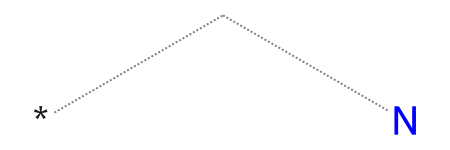

In [46]:
substructure

In [47]:
bottom = interpret[interpret["SHAP"]<0].sort_values(by=["SHAP"], ascending=True).reset_index(drop=True)
bottom

,name,SHAP,description,value
0,EState_VSA9,-1.899461e-03,EState VSA Descriptor 9 ( 4.69 <= x < 9.17),25.597761
1,Xc-5dv,-1.695582e-03,NaN,0.41602
2,ATSC5pe,-1.453426e-03,NaN,1.877479
3,IC1,-1.366807e-03,1-ordered neighborhood information content,4.187291
4,ATSC6m,-1.294809e-03,NaN,-1060.459011
...,...,...,...,...
296,Mfp1060,-7.850417e-07,NaN,0
297,SpDiam_Dzare,-5.955494e-07,NaN,196.13988
298,Mfp80,-4.340165e-07,NaN,1
299,MACCS129,-2.473584e-07,"[$(*~[CH2]~*~*~[CH2]~*),$([R]1@[CH2]@[R]@[R]@[...",0


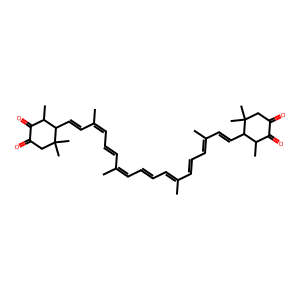

In [48]:
bottom_MACCS= bottom[bottom.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
bottom_MACCS_value= bottom[bottom.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
bottom_MACCS_shap= bottom[bottom.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0]     
bottom_MACCSsubstructure = Chem.MolFromSmarts(bottom_MACCS)

Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(bottom_MACCSsubstructure), width=200)  


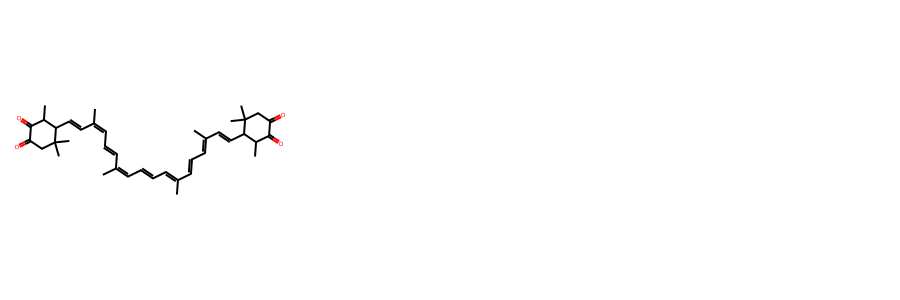

In [49]:
Draw.MolsToGridImage([m], highlightAtomLists=[m.GetSubstructMatch(bottom_MACCSsubstructure)], subImgSize=(300, 300), useSVG=False)

In [50]:
if (bottom[bottom.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0] == 1): 
    
    k = bottom[bottom.name.isin(desc.name.to_list()[-166:])]["description"].values[0]
    m = Chem.MolFromSmiles(smiles)
    substructure = Chem.MolFromSmarts(k)
    m_list.append(m)
    target_list.append(m.GetSubstructMatches(substructure))

else:
    
    print("Absence of Substructure")
    k = bottom[bottom.name.isin(desc.name.to_list()[-166:])]["description"].values[0]
    substructure = Chem.MolFromSmarts(k)
    print(substructure)

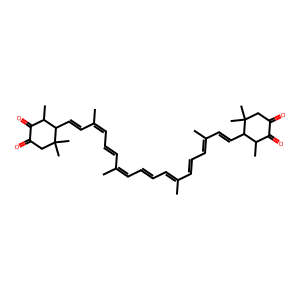

In [51]:
Draw.MolToImage(m, highlight=substructure)

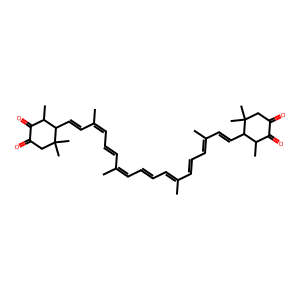

In [52]:
Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(substructure))

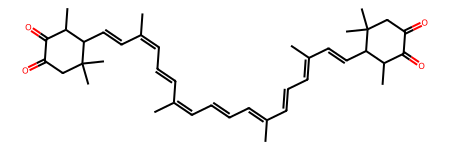

In [53]:
m

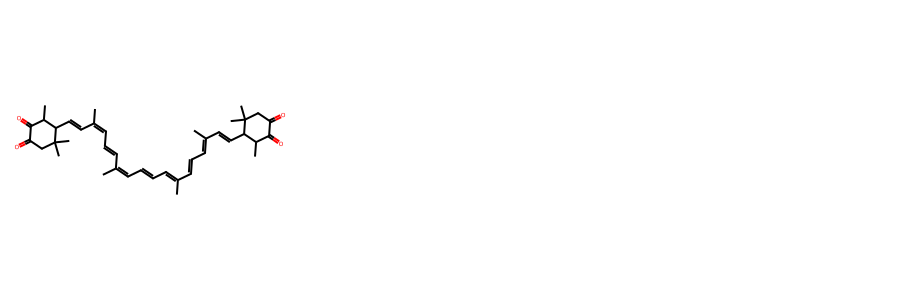

In [54]:
Draw.MolsToGridImage([m], highlightAtomLists=[m.GetSubstructMatch(substructure)], subImgSize=(300, 300), useSVG=True)

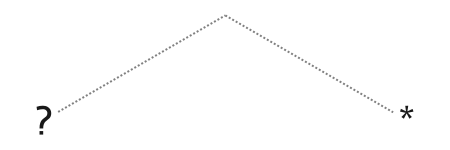

In [55]:
substructure

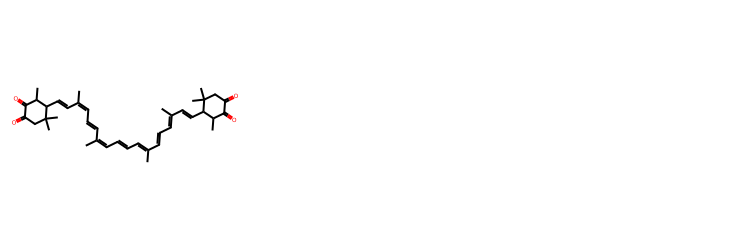

In [56]:
Draw.MolsToGridImage([m], subImgSize=(250,250), useSVG=True)